# Beam Training using Fully Connected Neural Networks
The first section loads the data, while the next two sections run FC NNs for beam training via classification and regression.

## THIS NOTEBOOK CONTAINS SAVED RESULTS FOR NR=12 AND D=0.57 (nn_sim6 - FIFTH POST-EXPERIMENT SIMULATION WITH FIXED SIM SCRIPT)
### NOT COMPLETE; RERUN IF RESULTS NEEDED

- Run data with 20 points and 200 points per DFT. Performance improves significantly for larger number of training points.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import comb

print(tf.__version__)

2.1.0


# Load data
Load data for a given SNR.  Repeat this cell for every SNR run.

In [7]:
print("../data/nn_sim{}".format(5) + "/test{}_{}.csv")

../data/nn_sim5/test{}_{}.csv


Data directory: ../data/nn_sim6/
Nr: 12, SNR: 20
	DFT data:  (10000, 17)
	PN data:   (10000, 12)
	Labels:    (10000, 1)
Nr: 12, SNR: 30
	DFT data:  (10000, 17)
	PN data:   (10000, 12)
	Labels:    (10000, 1)
Num DFT beams to use:  17
Num samples to use:    20000
Num PN beam combos:    1
	NOT USING RANDOM BEAMS -> FIRST 4 PN MEASUREMENTS USED!


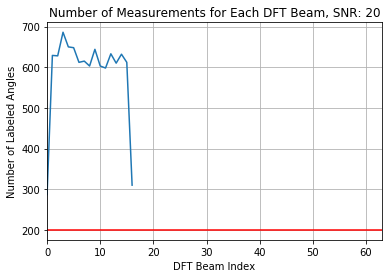

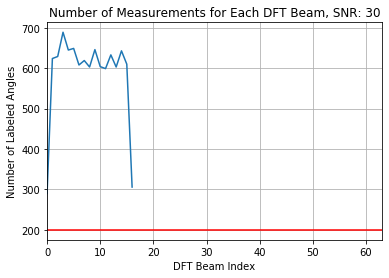

In [25]:
### Load Experimental Data ###
## Dataset Constants
Nr = 12
DATA_SNR = [20, 30]
NN_NUM = 5                  # Number in the name of this notebook
SIM_NUM = NN_NUM + 1        # Number used for simulation results (data input)

NUM_DFT = 17                # Number of DFT beams measured
NUM_ANGLES_PER_DFT = 200     # Number of measurements to use for a DFT (per each date; minimum required to be included)
NUM_TOTAL_MEAS = 12         # Number of total PN beam/measurements/features collected (in a file)
NUM_MEAS = 4               # Number of PN beams/measurements/features to use (5, 10, 15 typically) #TODO: NEED TO CHOOSE THE ANGLES SOMEHOW
NUM_PN_COMBO = 1           # Number of random combinations of measurements to run with the algorithm (to ensure the results aren't dependent on beam)(limit NUM_TOTAL_MEAS choose NUM_MEAS)
                            # Set the NUM_PN_COMBO to 1 for the first NUM_MEAS PN beams (i.e. NOT random)
    
DATA_LINEAR_SCALE = True   # Rescale the data from log to linear (pRx is in dB)
DATA_ZERO_MEAN = False      # Offset the data by the mean features of the training data (same offset used for test data)
DATA_NORMALIZATION = True  # Scale the data (training and testing) to the maximum norm of the training data

DATA_DIR = "../data/nn_sim{}/".format(SIM_NUM)
print("Data directory: {}".format(DATA_DIR))
DATA_DFT_FILESTEM = DATA_DIR + "DFT_output_nr{}_{}dB.csv" #"../data/results_awv0_{}_{}_dft.csv"
DATA_PN_FILESTEM = DATA_DIR + "measurement_RSS_nr{}_{}dB.csv" #"../data/results_awv0_{}_{}_pn.csv"
DATA_LABELS_FILESTEM = DATA_DIR + "DFT_label_nr{}_{}dB.csv" #"../data/results_awv0_{}_{}_labels.csv"
ANGLE_LABEL_FILESTEM = DATA_DIR + "label_nr{}_{}dB.csv"

## Computed Constants
NUM_SNRS = len(DATA_SNR)
max_pn_combos = comb(NUM_TOTAL_MEAS, NUM_MEAS)
if (NUM_PN_COMBO > max_pn_combos):
    NUM_PN_COMBO = max_pn_combos.astype(int)

# Compute the PN beams to use for each PN combo set (number of combos = NUM_PN_COMBO)
PN_USE_BEAMS = np.zeros((NUM_PN_COMBO, NUM_MEAS))
if NUM_PN_COMBO > 1:
    # Using more than 1 combo -> randomly choose the combinations of beams
    for pn_i in np.arange(NUM_PN_COMBO):
        PN_USE_BEAMS[pn_i, :] = np.random.choice(NUM_TOTAL_MEAS, NUM_MEAS, replace=False)
elif NUM_PN_COMBO == 1:
    # Using only 1 combo -> Use the first NUM_MEAS beams
    PN_USE_BEAMS[0, :] = np.arange(NUM_MEAS)
else:
    # Invalid number of combos -> error out
    print("INVALID NUMBER OF PN MEASUREMENTS {} -- RERUN WITH A NEW NUMBER".format(NUM_PN_COMBO))
    
PN_USE_BEAMS = PN_USE_BEAMS.astype(int)

## Loop through each test date and determine the data to use
dft_use_all = np.zeros((NUM_SNRS, NUM_DFT))
dft_use_all_num = np.zeros((NUM_SNRS, NUM_DFT))
for snr_ind in np.arange(NUM_SNRS):

    ## Get the file names
    SNR_i = DATA_SNR[snr_ind]
    print("Nr: {}, SNR: {}".format(Nr, SNR_i))
    dft_file = DATA_DFT_FILESTEM.format(Nr, SNR_i)
    pn_file = DATA_PN_FILESTEM.format(Nr, SNR_i)
    labels_file = DATA_LABELS_FILESTEM.format(Nr, SNR_i)

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_pn = pd.read_csv(pn_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    df_dft = df_dft.T
    df_pn = df_pn.T
    df_labels = (df_labels - 1).T
    print("\tDFT data: ", df_dft.shape)
    print("\tPN data:  ", df_pn.shape)
    print("\tLabels:   ", df_labels.shape)

    ## Pickout the data to use
    u, c = np.unique(df_labels, return_counts=True)
    plt.figure()
    plt.plot(u, c)
    plt.title("Number of Measurements for Each DFT Beam, SNR: {}".format(SNR_i))
    plt.xlabel("DFT Beam Index")
    plt.ylabel("Number of Labeled Angles")
    plt.grid(True)
    plt.xlim(0, 63)
    plt.axhline(y=NUM_ANGLES_PER_DFT, color='r', linestyle='-')

    # Pick the DFT indices just based on meeting the minimum number of angles required
    dft_valid_mask = u[c >= NUM_ANGLES_PER_DFT].astype(int)
    dft_use_all[snr_ind, dft_valid_mask] = True
    dft_use_all_num[snr_ind, dft_valid_mask] = c[c >= NUM_ANGLES_PER_DFT]
    
pick_dft = np.all(dft_use_all, 0)
dft_use = np.nonzero(pick_dft)[0]
dft_use_num = dft_use_all_num[:,pick_dft].astype(int)
NUM_CLASSES = len(dft_use)
print("Num DFT beams to use: ", NUM_CLASSES)
print("Num samples to use:   ", np.sum(dft_use_num))
print("Num PN beam combos:   ", NUM_PN_COMBO)
if NUM_PN_COMBO == 1:
    print("\tNOT USING RANDOM BEAMS -> FIRST {} PN MEASUREMENTS USED!".format(NUM_MEAS))

In [26]:
# Running dictonaries for the data
train_data_dict = {}
test_data_dict = {}
val_data_dict = {}
train_labels_dict = {}
test_labels_dict = {}
val_labels_dict = {}
train_classes_dict = {}
test_classes_dict = {}
dft_rssi_dict = {}

# The actual loop
for snr_ind in np.arange(NUM_SNRS):
#for date_i in np.arange(NUM_DATES):

    ## Get the file names
    SNR_i = DATA_SNR[snr_ind]
    print("Nr: {}, SNR: {}".format(Nr, SNR_i))
    dft_file = DATA_DFT_FILESTEM.format(Nr, SNR_i)
    pn_file = DATA_PN_FILESTEM.format(Nr, SNR_i)
    labels_file = DATA_LABELS_FILESTEM.format(Nr, SNR_i)

    ## Extract the data into Pandas dataframes
    # Number of rows = number of measurements/physical angles
    # Number of columns = number of beams (for DFT and PN; labels should only have 1)
    df_dft = pd.read_csv(dft_file, header=None)
    df_pn = pd.read_csv(pn_file, header=None)
    df_labels = pd.read_csv(labels_file, header=None)
    df_dft = df_dft.T
    df_pn = df_pn.T
    df_labels = (df_labels - 1).T
    print("\tDFT data: ", df_dft.shape)
    print("\tPN data:  ", df_pn.shape)
    print("\tLabels:   ", df_labels.shape)
    arr_pn = df_pn.to_numpy()
    arr_dft = df_dft.to_numpy()

#     ## Pickout the data to use
#     u, c = np.unique(df_labels, return_counts=True)
#     plt.figure()
#     plt.plot(u, c)
#     plt.title("Number of Measurements for Each DFT Beam, Date: {}".format(SNR_i))
#     plt.xlabel("DFT Beam Index")
#     plt.ylabel("Number of Labeled Angles")
#     plt.grid(True)
#     plt.xlim(0, 63)
#     plt.axhline(y=NUM_ANGLES_PER_DFT, color='r', linestyle='-')

#     # Pick the DFT indices just based on meeting the minimum number of angles required
#     dft_use = u[c >= NUM_ANGLES_PER_DFT].astype(int)
#     dft_use_num = c[c >= NUM_ANGLES_PER_DFT]
    
    # Running dictionary for the data for each PN beam combo
    train_data_datei_dict = {}
    test_data_datei_dict = {}
    #val_data_datei_dict = {}
    train_labels_datei_dict = {}
    test_labels_datei_dict = {}
    #val_labels_datei_dict = {}
    train_classes_datei_dict = {}
    test_classes_datei_dict = {}
    dft_rssi_datei_dict = {}
    
    # Loop through all the PN beam combos
    for pn_i in np.arange(NUM_PN_COMBO):

        # Choose the points randomly from the points available (per each used DFT beam)
        train_data = np.array([])
        train_labels = np.array([])
        test_data = np.array([])
        test_labels = np.array([])
        train_classes = np.array([])
        test_classes = np.array([])
        test_dftrssi = np.array([])
        
        for dft_i in np.arange(len(dft_use)):

            # Find all potential PN beam measurements to use for this DFT beam label
            wh = np.where(df_labels == dft_use[dft_i])
            pn_all_i_temp = arr_pn[wh[0], :]
            pn_all_i = pn_all_i_temp[:,PN_USE_BEAMS[pn_i]]
            dft_all_i = arr_dft[wh[0], :]
            #print("------ PN select size: {}".format(pn_all_i.shape))
#             print(dft_use[dft_i])
#             print(len(wh[0]))
#             print(pn_all_i.shape)

            # Randomly pick the indices to include
            pn_all_ind = np.arange(dft_use_num[snr_ind, dft_i])
            pn_choice_ind = np.random.choice(pn_all_ind, NUM_ANGLES_PER_DFT, replace=False)
            pn_choice = pn_all_i[pn_choice_ind, :]
            pn_nchoice_ind = np.delete(pn_all_ind, pn_choice_ind)
            pn_nchoice = pn_all_i[pn_nchoice_ind, :]
            dft_nchoice = dft_all_i[pn_nchoice_ind, :]
    
            choice_labels = dft_use[dft_i] * np.ones((NUM_ANGLES_PER_DFT, 1))
            nchoice_labels = dft_use[dft_i] * np.ones((dft_use_num[snr_ind, dft_i] - NUM_ANGLES_PER_DFT, 1))
            choice_classes = dft_i * np.ones((NUM_ANGLES_PER_DFT, 1))
            nchoice_classes = dft_i * np.ones((dft_use_num[snr_ind, dft_i] - NUM_ANGLES_PER_DFT, 1))
            if dft_i == 0:
                train_data = pn_choice
                train_labels = choice_labels
                test_data = pn_nchoice
                test_labels = nchoice_labels
                train_classes = choice_classes
                test_classes = nchoice_classes
                test_dftrssi = dft_nchoice
            else:
                train_data = np.vstack((train_data, pn_choice))
                train_labels = np.vstack((train_labels, choice_labels))
                test_data = np.vstack((test_data, pn_nchoice))
                test_labels = np.vstack((test_labels, nchoice_labels))
                train_classes = np.vstack((train_classes, choice_classes))
                test_classes = np.vstack((test_classes, nchoice_classes))
                test_dftrssi = np.vstack((test_dftrssi, dft_nchoice))
        
        # Store the results in the date dictionary
        print("\t\tTraining data: {}; labels: {}; classes: {} - PN combo {}".format(train_data.shape, train_labels.shape, train_classes.shape, pn_i))
        print("\t\tTesting data:  {}; labels: {}; classes: {} - PN combo {}".format(test_data.shape, test_labels.shape, test_classes.shape, pn_i))
        train_data_datei_dict[pn_i] = train_data
        test_data_datei_dict[pn_i] = test_data
        #val_data_datei_dict[pn_i] = val_data
        train_labels_datei_dict[pn_i] = train_labels.astype(int)
        test_labels_datei_dict[pn_i] = test_labels.astype(int)
        #val_labels_datei_dict[pn_i] = val_labels
        train_classes_datei_dict[pn_i] = train_classes.astype(int)
        test_classes_datei_dict[pn_i] = test_classes.astype(int)
        
        # Save the DFT beam RSSI for future gain loss performance evaluation
        dft_rssi_datei_dict[pn_i] = test_dftrssi
        
    # Store the results in the overall dictionaries
    print("\tTraining dictionaries - data: {}; labels: {}; classes: {}".format(len(train_data_datei_dict), len(train_labels_datei_dict), len(train_classes_datei_dict)))
    print("\tTesting dictionaries - data:  {}; labels: {}; classes: {}".format(len(test_data_datei_dict), len(test_labels_datei_dict), len(test_classes_datei_dict)))
    train_data_dict[SNR_i] = train_data_datei_dict
    test_data_dict[SNR_i] = test_data_datei_dict
    #val_data_dict[SNR_i] = val_data_datei_dict
    train_labels_dict[SNR_i] = train_labels_datei_dict
    test_labels_dict[SNR_i] = test_labels_datei_dict
    #val_labels_dict[SNR_i] = val_labels_datei_dict
    train_classes_dict[SNR_i] = train_classes_datei_dict
    test_classes_dict[SNR_i] = test_classes_datei_dict
    dft_rssi_dict[SNR_i] = dft_rssi_datei_dict
    
## Final variable cleanup
train_data_all = {}
train_labels_all = {}
train_classes_all = {}
# val_data_all = {}
# val_labels_all = {}
# val_classes_all = {}
test_data_all = {}
test_labels_all = {}
test_classes_all = {}
test_dftrssi_all = {}

print("\nCreating total training/validation/test datasets:")
for pn_i in np.arange(NUM_PN_COMBO):
    # Running variables
    train_data_pni = np.array([])
    train_labels_pni = np.array([])
    train_classes_pni = np.array([])
    # val_data_pni = np.array([])
    # val_labels_pni = np.array([])
    # val_classes_pni = np.array([])
    test_data_pni = np.array([])
    test_labels_pni = np.array([])
    test_classes_pni = np.array([])
    test_dftrssi_pni = np.array([])
    importeddata = False
    
    # Combine the data for each set of PN beams/measurements
    for snr_i in np.arange(len(train_data_dict)):
        #print("\ttrain: {}, val: {}".format(train_data_dict[DATA_SNR[snr_i]][pn_i].shape, val_data_dict[DATA_SNR[snr_i]][pn_i].shape))
        print("\ttrain: {}".format(train_data_dict[DATA_SNR[snr_i]][pn_i].shape))
        if not importeddata:
            train_data_pni = train_data_dict[DATA_SNR[snr_i]][pn_i]
            train_labels_pni = train_labels_dict[DATA_SNR[snr_i]][pn_i]
            train_classes_pni = train_classes_dict[DATA_SNR[snr_i]][pn_i]
    #         val_data_pni = val_data_dict[DATA_SNR[snr_i]][pn_i]
    #         val_labels_pni = val_labels_dict[DATA_SNR[snr_i]][pn_i]
            test_data_pni = test_data_dict[DATA_SNR[snr_i]][pn_i]
            test_labels_pni = test_labels_dict[DATA_SNR[snr_i]][pn_i]
            test_classes_pni = test_classes_dict[DATA_SNR[snr_i]][pn_i]
            test_dftrssi_pni = dft_rssi_dict[DATA_SNR[snr_i]][pn_i]
            importeddata = True
        else:
            train_data_pni = np.vstack((train_data_pni, train_data_dict[DATA_SNR[snr_i]][pn_i]))
            train_labels_pni = np.vstack((train_labels_pni, train_labels_dict[DATA_SNR[snr_i]][pn_i]))
            train_classes_pni = np.vstack((train_classes_pni, train_classes_dict[DATA_SNR[snr_i]][pn_i]))
    #         val_data_pni = np.vstack((val_data_pni, val_data_dict[DATA_SNR[snr_i]][pn_i]))
    #         val_labels_pni = np.vstack((val_labels_pni, val_labels_dict[DATA_SNRR[snr_i]][pn_i]))
            test_data_pni = np.vstack((test_data_pni, test_data_dict[DATA_SNR[snr_i]][pn_i]))
            test_labels_pni = np.vstack((test_labels_pni, test_labels_dict[DATA_SNR[snr_i]][pn_i]))
            test_classes_pni = np.vstack((test_classes_pni, test_classes_dict[DATA_SNR[snr_i]][pn_i]))
            test_dftrssi_pni = np.vstack((test_dftrssi_pni, dft_rssi_dict[DATA_SNR[snr_i]][pn_i]))
    
    # Store the combined data for this set of features into the overall dictionary
    train_data_all[pn_i] = train_data_pni
    train_labels_all[pn_i] = train_labels_pni
    train_classes_all[pn_i] = train_classes_pni
    test_data_all[pn_i] = test_data_pni
    test_labels_all[pn_i] = test_labels_pni
    test_classes_all[pn_i] = test_classes_pni
    test_dftrssi_all[pn_i] = test_dftrssi_pni

## Data scaling and normalization
print("\nRunning data scaling and normalization...")
NUM_TRAIN = np.zeros((NUM_PN_COMBO, 1))
for pn_i in np.arange(NUM_PN_COMBO):
    print("\tTraining data range: ({}, {}) --- PN set {}".format(np.min(train_data_all[pn_i]), np.max(train_data_all[pn_i]), pn_i))
    if DATA_LINEAR_SCALE:
        print("\t\tUsing linear scale data...")
        train_data_all[pn_i] = 10**(train_data_all[pn_i]/10)
        test_data_all[pn_i] = 10**(test_data_all[pn_i]/10)
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = 10**(test_data_dict[DATA_SNR[snr_i]][pn_i]/10)

    if DATA_ZERO_MEAN:
        train_mean = np.mean(train_data_all[pn_i], 0)
        print("\t\tUsing zero-mean offset; offset by {}...".format(train_mean))
        train_data_all[pn_i] = train_data_all[pn_i] - train_mean
        test_data_all[pn_i] = test_data_all[pn_i] - train_mean
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = test_data_dict[DATA_SNR[snr_i]][pn_i] - train_mean

    if DATA_NORMALIZATION:
        data_scale = np.max(np.linalg.norm(train_data_all[pn_i], 2, 1))
        print("\t\tData scale factor (max norm): {}...".format(data_scale))
        train_data_all[pn_i] = train_data_all[pn_i]/data_scale
        test_data_all[pn_i] = test_data_all[pn_i]/data_scale
        for snr_i in np.arange(len(test_data_dict)):
            test_data_dict[DATA_SNR[snr_i]][pn_i] = test_data_dict[DATA_SNR[snr_i]][pn_i]/data_scale
        print("\t\tNew training data range: {}, {}".format(np.min(train_data_all[pn_i]), np.max(train_data_all[pn_i])))

    NUM_TRAIN[pn_i] = int(train_data_all[pn_i].shape[0])
    print("\t\tTotal training dataset size (PN set {}): {}".format(pn_i, train_data_all[pn_i].shape))
    print("\t\tTotal test dataset size     (PN set {}): {}".format(pn_i, test_data_all[pn_i].shape))
    # NUM_VAL = int(val_data_all.shape[0])
    # print("Total validation dataset size: {}".format(val_data_all.shape))
    
# Save the total test data to a new dictionary key (useful for test loops)
test_data_dict['ALL'] = test_data_all
test_labels_dict['ALL'] = test_labels_all
test_classes_dict['ALL'] = test_classes_all
dft_rssi_dict['ALL'] = test_dftrssi_all

Nr: 12, SNR: 20
	DFT data:  (10000, 17)
	PN data:   (10000, 12)
	Labels:    (10000, 1)
		Training data: (3400, 4); labels: (3400, 1); classes: (3400, 1) - PN combo 0
		Testing data:  (6600, 4); labels: (6600, 1); classes: (6600, 1) - PN combo 0
	Training dictionaries - data: 1; labels: 1; classes: 1
	Testing dictionaries - data:  1; labels: 1; classes: 1
Nr: 12, SNR: 30
	DFT data:  (10000, 17)
	PN data:   (10000, 12)
	Labels:    (10000, 1)
		Training data: (3400, 4); labels: (3400, 1); classes: (3400, 1) - PN combo 0
		Testing data:  (6600, 4); labels: (6600, 1); classes: (6600, 1) - PN combo 0
	Training dictionaries - data: 1; labels: 1; classes: 1
	Testing dictionaries - data:  1; labels: 1; classes: 1

Creating total training/validation/test datasets:
	train: (3400, 4)
	train: (3400, 4)

Running data scaling and normalization...
	Training data range: (0.0043826, 2.6417) --- PN set 0
		Using linear scale data...
		Data scale factor (max norm): 2.885254481277909...
		New training data

# Classification Method - Only Discrete Beams Considered
Beam training can be thought of as a classification problem; optimize for the best training beam/code quickly (one shot or a few shots).  Compressive sensing methods are able to reduce the number of training beams required to predict the AoA, but ML methods might improve on this.

In [14]:
### Dictionaries to hold metrics for different number of measurements ###
# RUN ONLY WHEN STARTING A NEW SET OF PLOTS
return # to prevent rerunning between different numbers of measurements
all_test_acc = {}
all_confusionMat = {}
all_RMSE_disc = {}
all_RMSE_cont = {}
all_pe_byLabel = {}
all_gainLoss = {}
GAIN_LOSS_PERCENTILES = np.arange(0, 110, 10)

data_scale = 1

# Custom loss function
def cLoss(yTrue,yPred):
    return K.sum(K.log(yTrue) - K.log(yPred))


In [15]:
### Dictionaries to hold metrics for different runs ###
# Keys: Number of features used to train
class_test_acc = {}
class_confusionMat = {}
class_RMSE_disc = {}
class_RMSE_cont = {}


### NN for 12 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 571us/sample - loss: 1.7927 - sparse_categorical_accuracy: 0.5868
Epoch 2/75
2040/2040 [==============================] - 0s 203us/sample - loss: 0.5734 - sparse_categorical_accuracy: 0.8578
Epoch 3/75
2040/2040 [==============================] - 0s 203us/sample - loss: 0.3977 - sparse_categorical_accuracy: 0.8745
Epoch 4/75
2040/2040 [==============================] - 0s 194us/sample - loss: 0.3279 - sparse_categorical_accuracy: 0.8941
Epoch 5/75
2040/2040 [==============================] - 0s 190us/sample - loss: 0.2916 - sparse_categorical_accuracy: 0.9000
Epoch 6/75
2040/2040 [==============================] - 0s 191us/sample - loss: 0.2742 - sparse_categorical_accuracy: 0.8995
Epoch 7/75
2040/2040 [==============================] - 0s 194us/sample - loss: 0.2597 - sparse_categorical_accuracy: 0.9054
Epoch 8/75
2040/2040 [==============================] - 0s 194us/samp

Text(0.5, 0, 'Epoch')

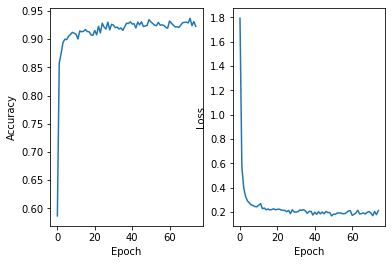

In [18]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.3059 - sparse_categorical_accuracy: 0.9031
	Test accuracy: 0.903118


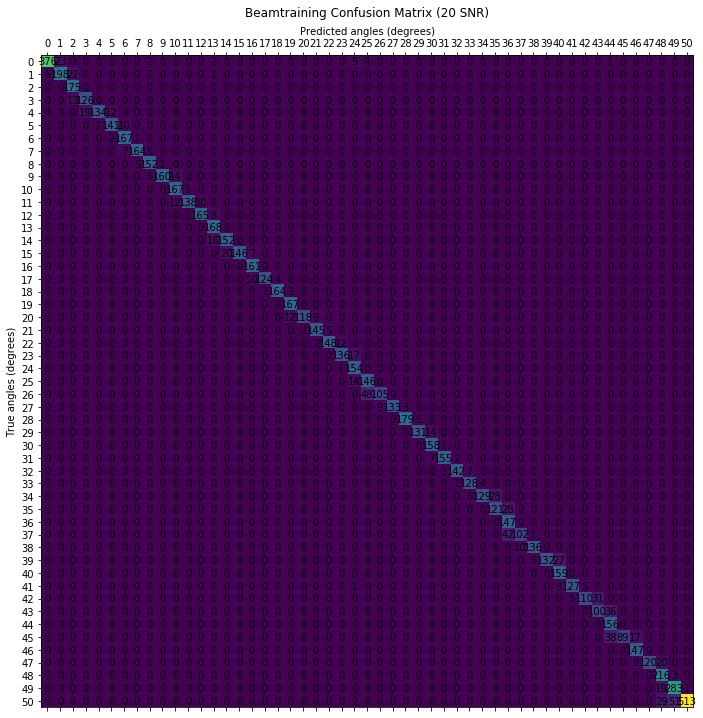

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2564 - sparse_categorical_accuracy: 0.9148
	Test accuracy: 0.9148107


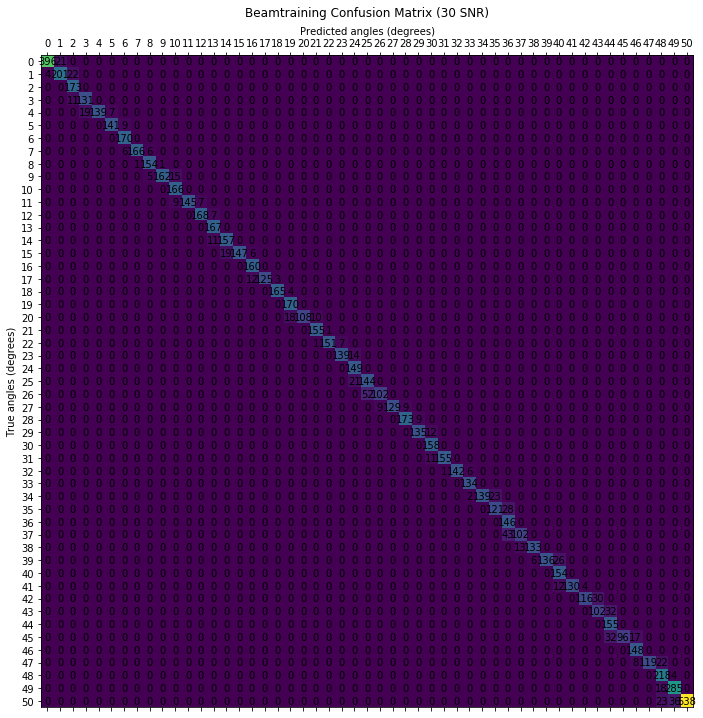

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.2812 - sparse_categorical_accuracy: 0.9090
	Test accuracy: 0.90896434


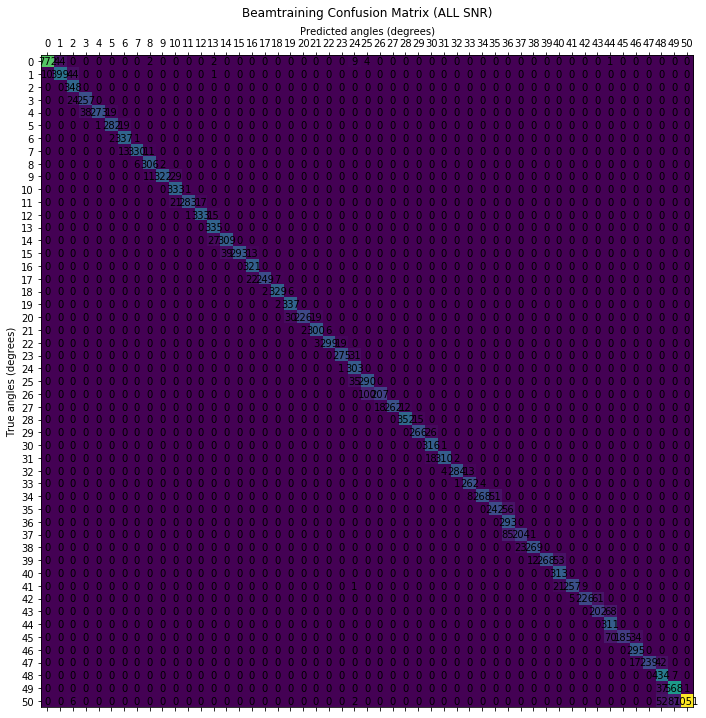


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.     0.  ]
 [ 10.     0.  ]
 [ 20.     0.  ]
 [ 30.     0.  ]
 [ 40.     0.  ]
 [ 50.     0.  ]
 [ 60.     0.  ]
 [ 70.     0.  ]
 [ 80.     0.  ]
 [ 90.     0.  ]
 [100.    41.39]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.     0.  ]
 [ 10.     0.  ]
 [ 20.     0.  ]
 [ 30.     0.  ]
 [ 40.     0.  ]
 [ 50.     0.  ]
 [ 60.     0.  ]
 [ 70.     0.  ]
 [ 80.     0.  ]
 [ 90.     0.  ]
 [100.     2.83]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.     0.  ]
 [ 10.     0.  ]
 [ 20.     0.  ]
 [ 30.     0.  ]
 [ 40.     0.  ]
 [ 50.     0.  ]
 [ 60.     0.  ]
 [ 70.     0.  ]
 [ 80.     0.  ]
 [ 90.     0.  ]
 [100.    41.39]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.9031180143356323
	SNR: 30; Accuracy: 0.9148107171058655


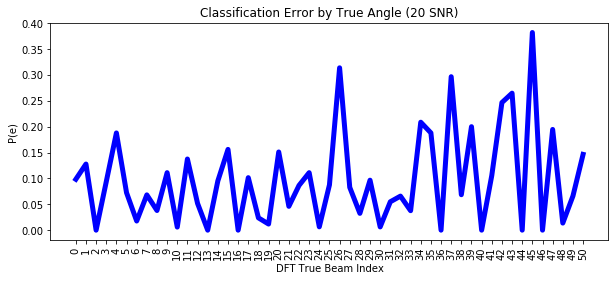

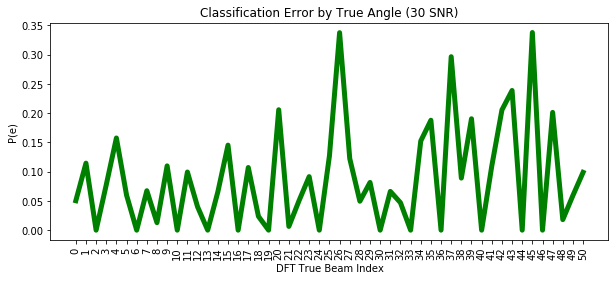

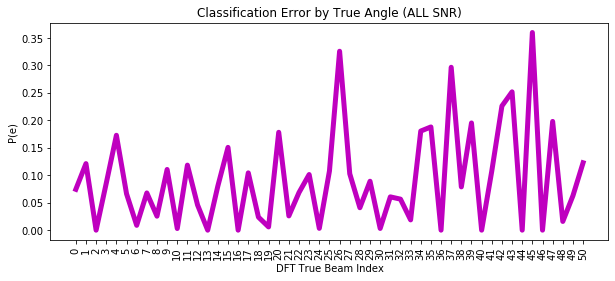

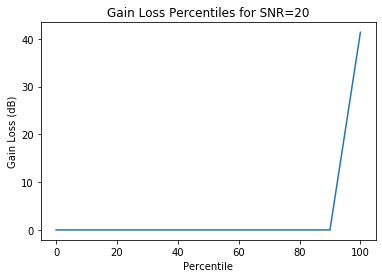

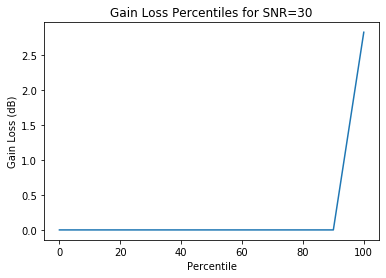

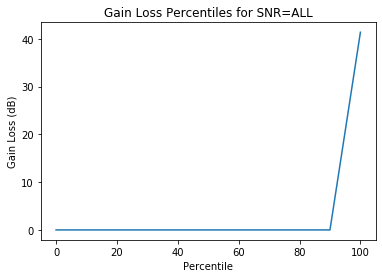

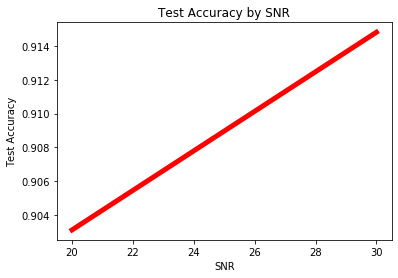

In [19]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 10 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 549us/sample - loss: 1.7061 - sparse_categorical_accuracy: 0.6196
Epoch 2/75
2040/2040 [==============================] - 0s 230us/sample - loss: 0.5982 - sparse_categorical_accuracy: 0.8618
Epoch 3/75
2040/2040 [==============================] - 0s 229us/sample - loss: 0.4512 - sparse_categorical_accuracy: 0.8730
Epoch 4/75
2040/2040 [==============================] - 0s 229us/sample - loss: 0.3682 - sparse_categorical_accuracy: 0.8882
Epoch 5/75
2040/2040 [==============================] - 0s 232us/sample - loss: 0.3427 - sparse_categorical_accuracy: 0.8902
Epoch 6/75
2040/2040 [==============================] - 0s 229us/sample - loss: 0.3267 - sparse_categorical_accuracy: 0.8936
Epoch 7/75
2040/2040 [==============================] - 0s 235us/sample - loss: 0.3136 - sparse_categorical_accuracy: 0.8985
Epoch 8/75
2040/2040 [==============================] - 0s 228us/samp

Text(0.5, 0, 'Epoch')

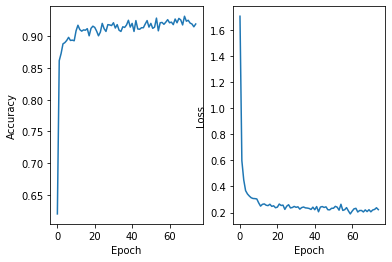

In [22]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.1842 - sparse_categorical_accuracy: 0.9285
	Test accuracy: 0.9285078


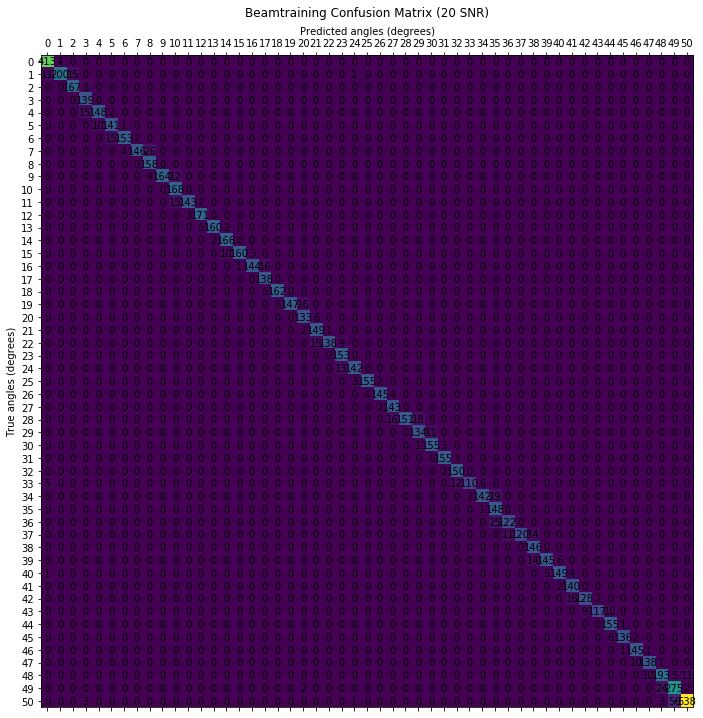

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.1322 - sparse_categorical_accuracy: 0.9437
	Test accuracy: 0.9436526


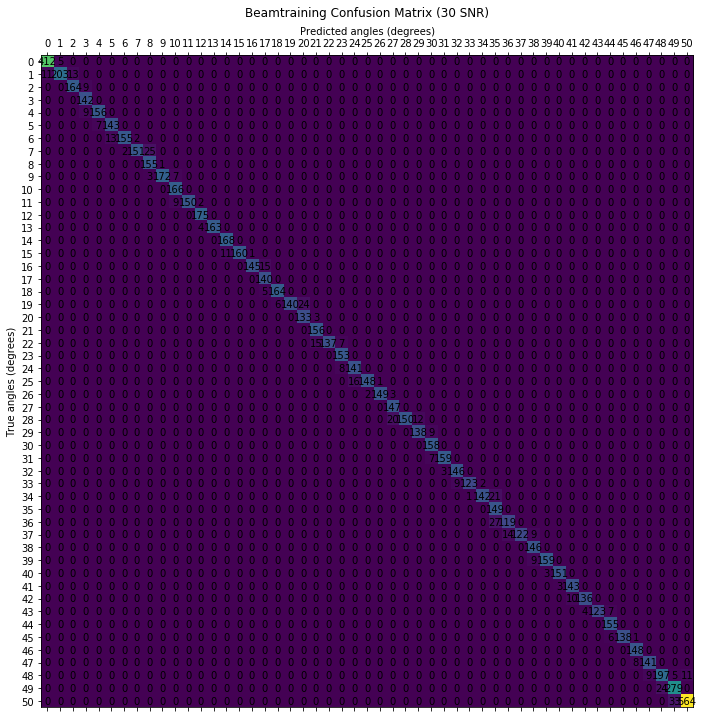

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.1582 - sparse_categorical_accuracy: 0.9361
	Test accuracy: 0.93608016


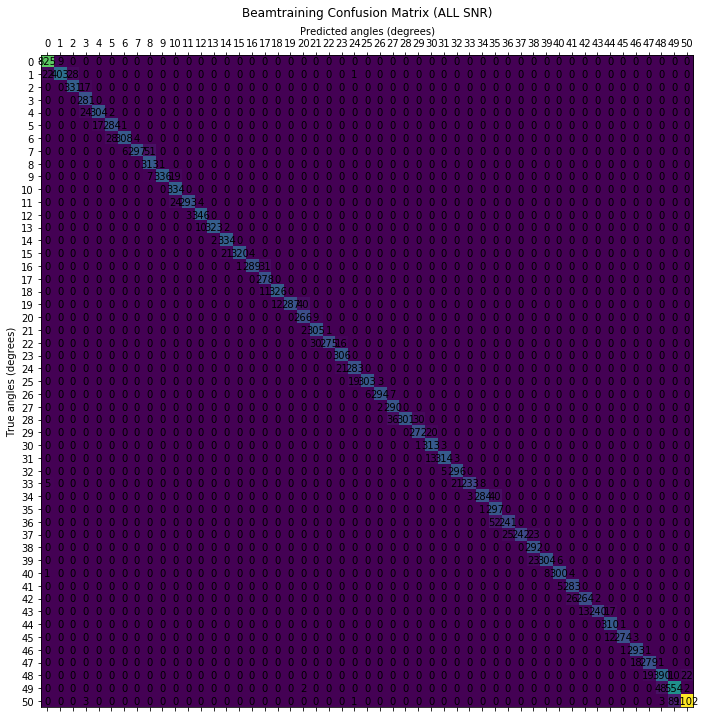


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.    ]
 [ 80.       0.    ]
 [ 90.       0.    ]
 [100.      38.4677]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.    ]
 [ 80.       0.    ]
 [ 90.       0.    ]
 [100.       2.8139]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.    ]
 [ 80.       0.    ]
 [ 90.       0.    ]
 [100.      38.4677]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.92850780487

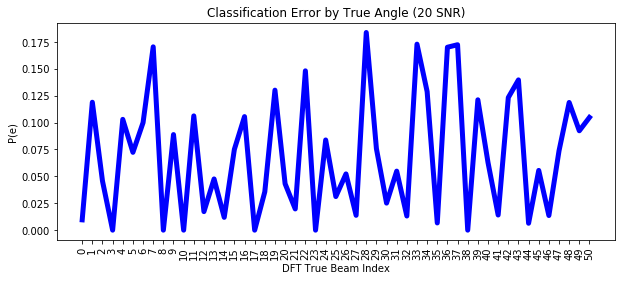

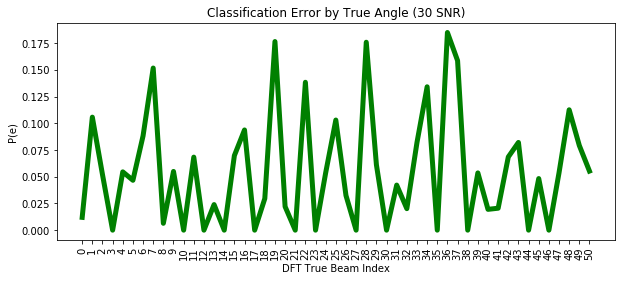

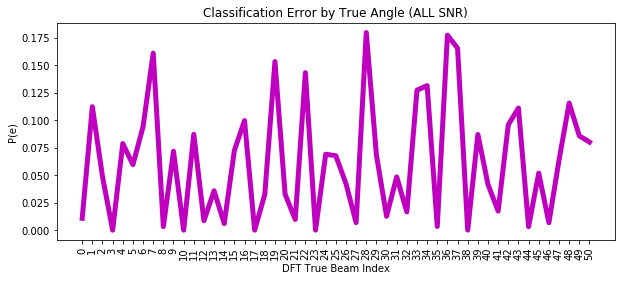

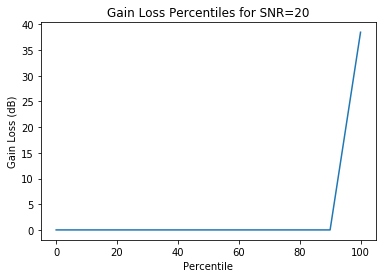

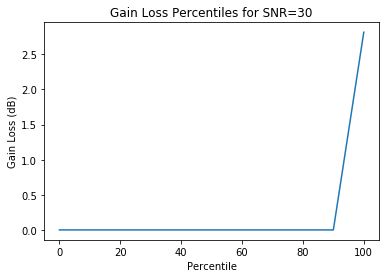

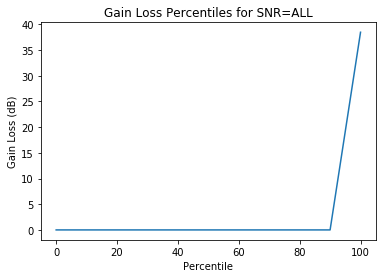

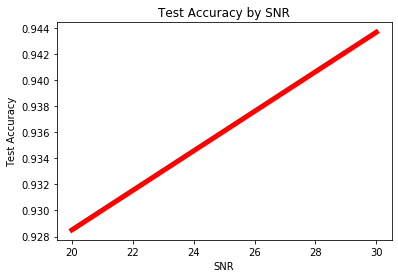

In [23]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 9 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 671us/sample - loss: 1.8131 - sparse_categorical_accuracy: 0.5794
Epoch 2/75
2040/2040 [==============================] - 1s 337us/sample - loss: 0.7360 - sparse_categorical_accuracy: 0.8181
Epoch 3/75
2040/2040 [==============================] - 1s 359us/sample - loss: 0.5275 - sparse_categorical_accuracy: 0.8578
Epoch 4/75
2040/2040 [==============================] - 1s 348us/sample - loss: 0.4360 - sparse_categorical_accuracy: 0.8657
Epoch 5/75
2040/2040 [==============================] - 1s 340us/sample - loss: 0.4181 - sparse_categorical_accuracy: 0.8711
Epoch 6/75
2040/2040 [==============================] - 1s 339us/sample - loss: 0.3798 - sparse_categorical_accuracy: 0.8789
Epoch 7/75
2040/2040 [==============================] - 1s 339us/sample - loss: 0.3676 - sparse_categorical_accuracy: 0.8794
Epoch 8/75
2040/2040 [==============================] - 1s 337us/samp

Text(0.5, 0, 'Epoch')

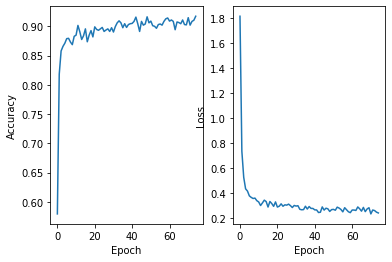

In [26]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2127 - sparse_categorical_accuracy: 0.9214
	Test accuracy: 0.9213808


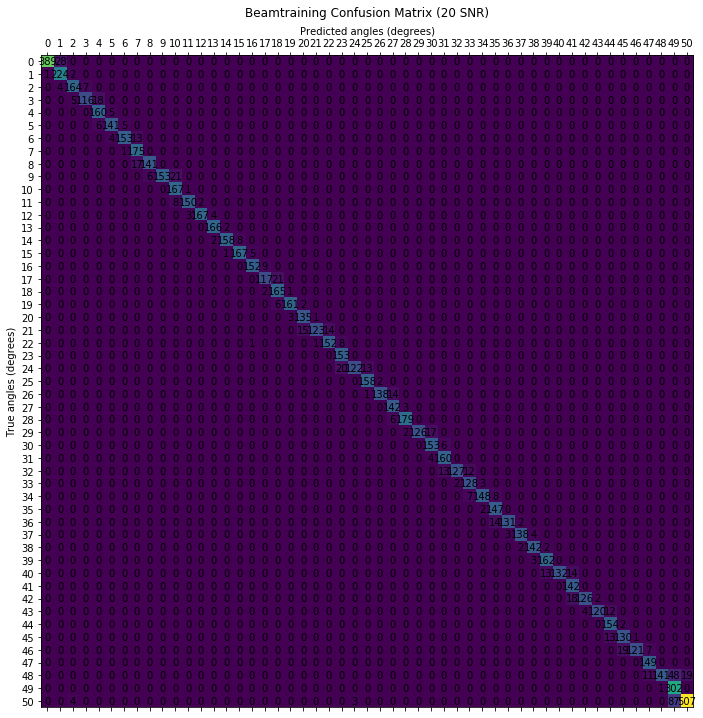

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.1627 - sparse_categorical_accuracy: 0.9375
	Test accuracy: 0.93752784


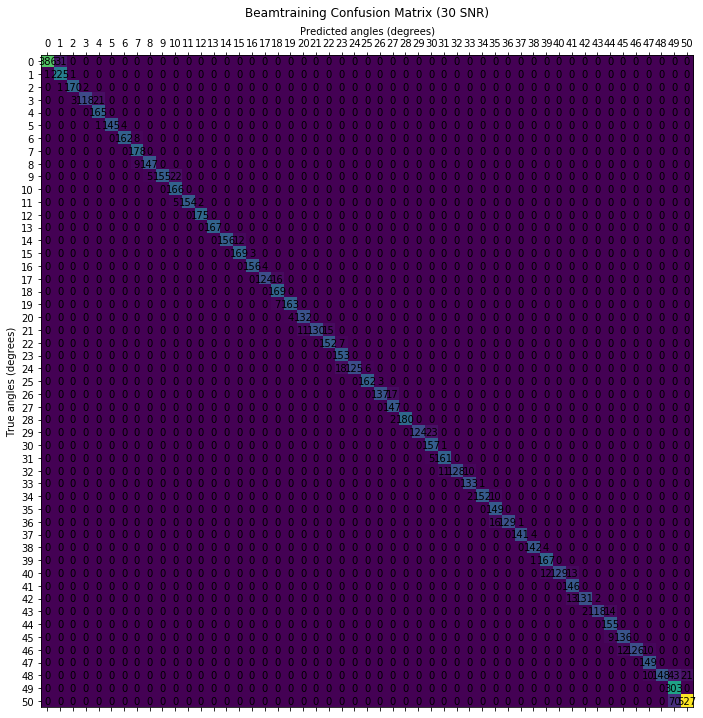

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.1877 - sparse_categorical_accuracy: 0.9295
	Test accuracy: 0.9294543


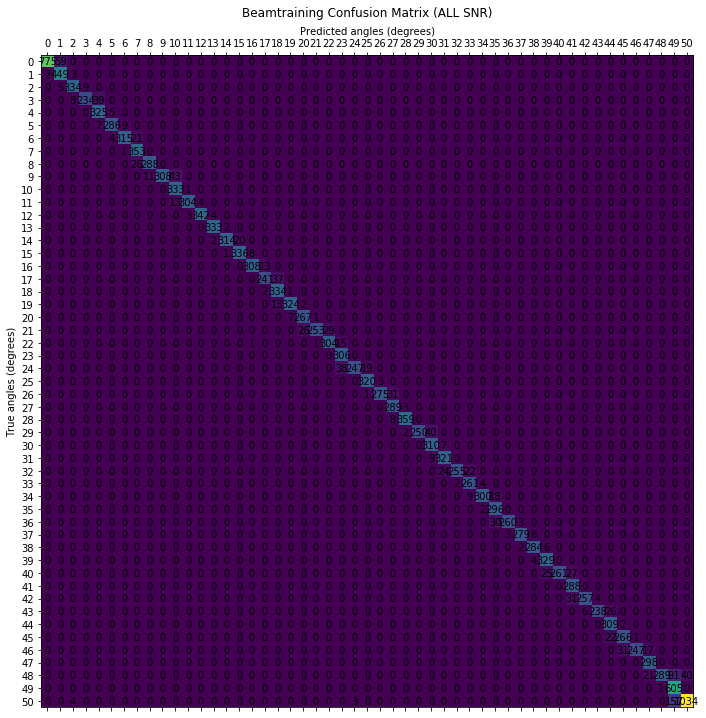


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     38.627]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.    ]
 [ 80.       0.    ]
 [ 90.       0.    ]
 [100.       5.4846]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     38.627]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.9213808178901672
	SNR: 30; Accuracy: 0.9375278353691101

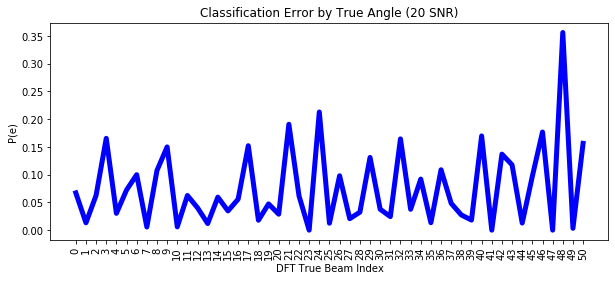

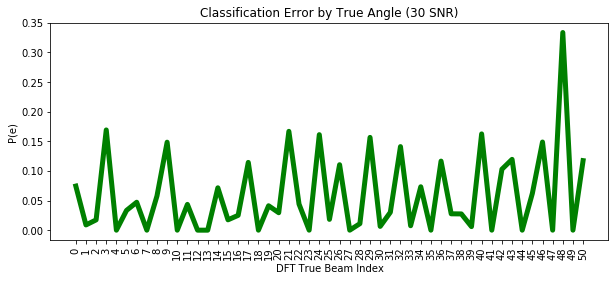

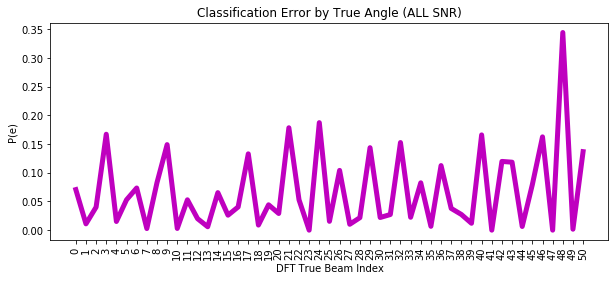

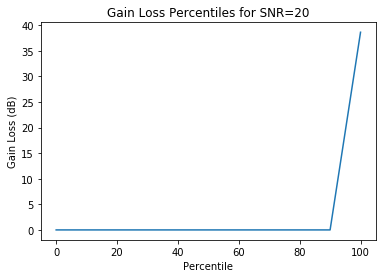

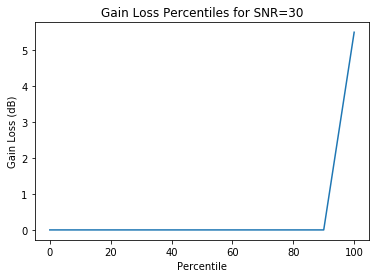

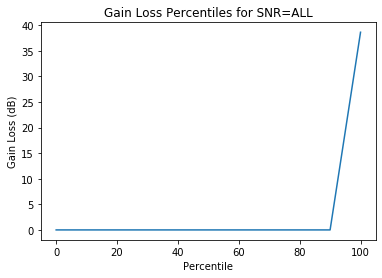

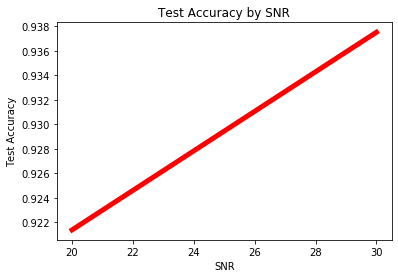

In [27]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 8 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 1s 604us/sample - loss: 1.9931 - sparse_categorical_accuracy: 0.5284
Epoch 2/75
2040/2040 [==============================] - 1s 290us/sample - loss: 0.9781 - sparse_categorical_accuracy: 0.7623
Epoch 3/75
2040/2040 [==============================] - 1s 293us/sample - loss: 0.7454 - sparse_categorical_accuracy: 0.8049
Epoch 4/75
2040/2040 [==============================] - 1s 290us/sample - loss: 0.6362 - sparse_categorical_accuracy: 0.8142
Epoch 5/75
2040/2040 [==============================] - 1s 293us/sample - loss: 0.5628 - sparse_categorical_accuracy: 0.8333
Epoch 6/75
2040/2040 [==============================] - 1s 292us/sample - loss: 0.5481 - sparse_categorical_accuracy: 0.8358
Epoch 7/75
2040/2040 [==============================] - 1s 291us/sample - loss: 0.5090 - sparse_categorical_accuracy: 0.8422
Epoch 8/75
2040/2040 [==============================] - 1s 291us/samp

Text(0.5, 0, 'Epoch')

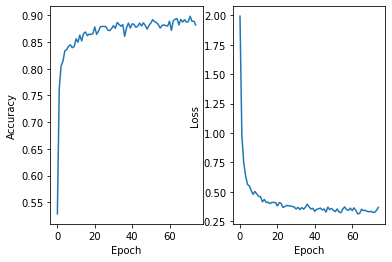

In [30]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2886 - sparse_categorical_accuracy: 0.8942
	Test accuracy: 0.8942093


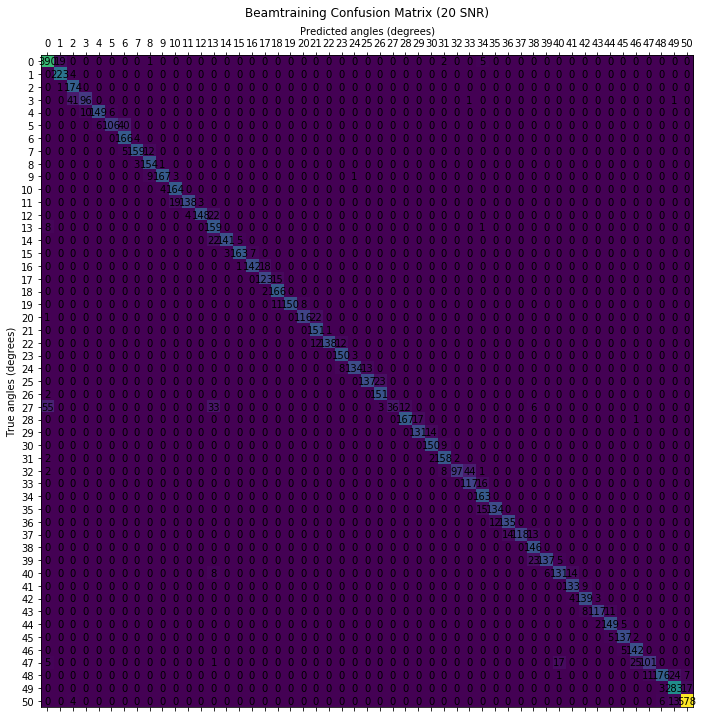

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.2137 - sparse_categorical_accuracy: 0.9154
	Test accuracy: 0.9153675


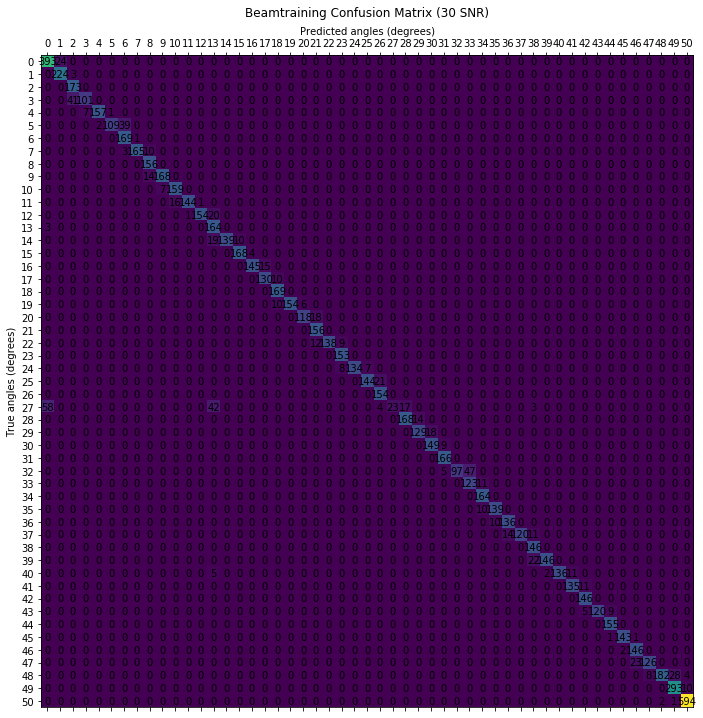

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.2511 - sparse_categorical_accuracy: 0.9048
	Test accuracy: 0.90478843


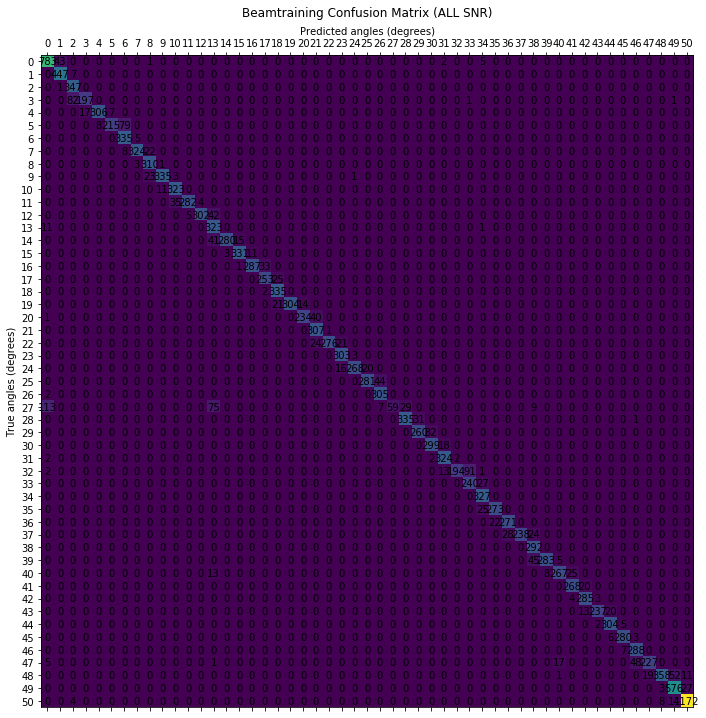


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 3.4000e-02]
 [1.0000e+02 5.5998e+01]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.     0.  ]
 [ 10.     0.  ]
 [ 20.     0.  ]
 [ 30.     0.  ]
 [ 40.     0.  ]
 [ 50.     0.  ]
 [ 60.     0.  ]
 [ 70.     0.  ]
 [ 80.     0.  ]
 [ 90.     0.  ]
 [100.    50.16]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.   ]
 [100.     55.998]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.8942093253135681
	SNR: 30; Accura

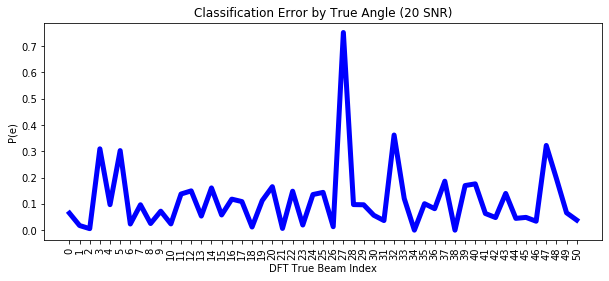

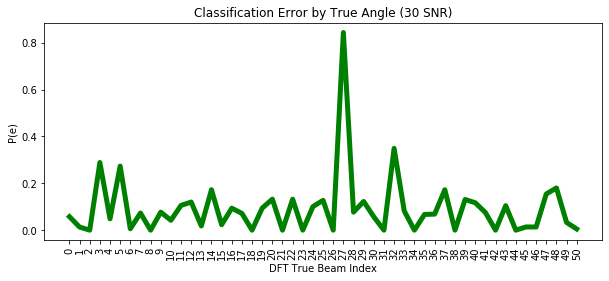

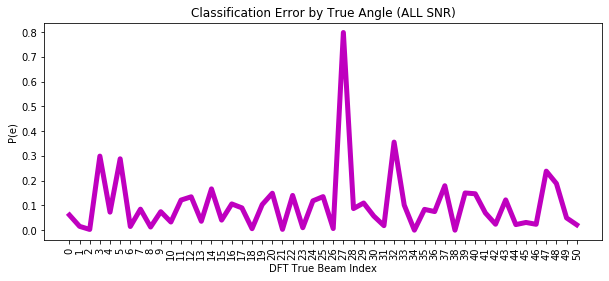

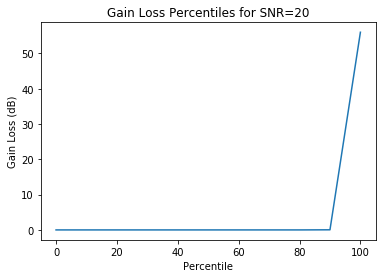

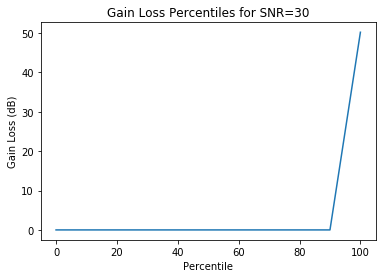

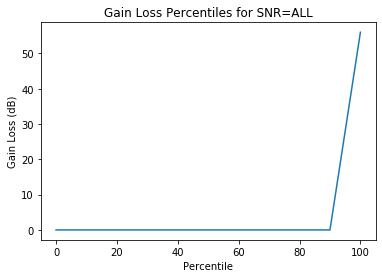

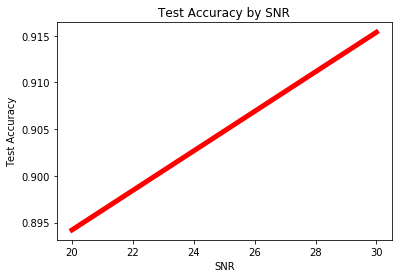

In [31]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim4_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 7 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 2s 838us/sample - loss: 2.1369 - sparse_categorical_accuracy: 0.4711
Epoch 2/75
2040/2040 [==============================] - 1s 452us/sample - loss: 1.1344 - sparse_categorical_accuracy: 0.7108
Epoch 3/75
2040/2040 [==============================] - 1s 435us/sample - loss: 0.8896 - sparse_categorical_accuracy: 0.7578
Epoch 4/75
2040/2040 [==============================] - 1s 438us/sample - loss: 0.7901 - sparse_categorical_accuracy: 0.7730
Epoch 5/75
2040/2040 [==============================] - 1s 435us/sample - loss: 0.7186 - sparse_categorical_accuracy: 0.7877
Epoch 6/75
2040/2040 [==============================] - 1s 432us/sample - loss: 0.6815 - sparse_categorical_accuracy: 0.8029
Epoch 7/75
2040/2040 [==============================] - 1s 454us/sample - loss: 0.6532 - sparse_categorical_accuracy: 0.8064
Epoch 8/75
2040/2040 [==============================] - 1s 434us/samp

Text(0.5, 0, 'Epoch')

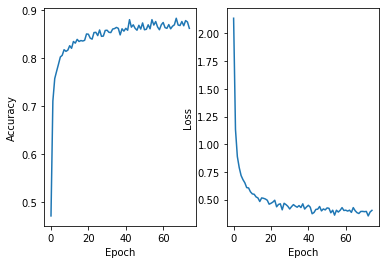

In [34]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.4805 - sparse_categorical_accuracy: 0.8606
	Test accuracy: 0.8605791


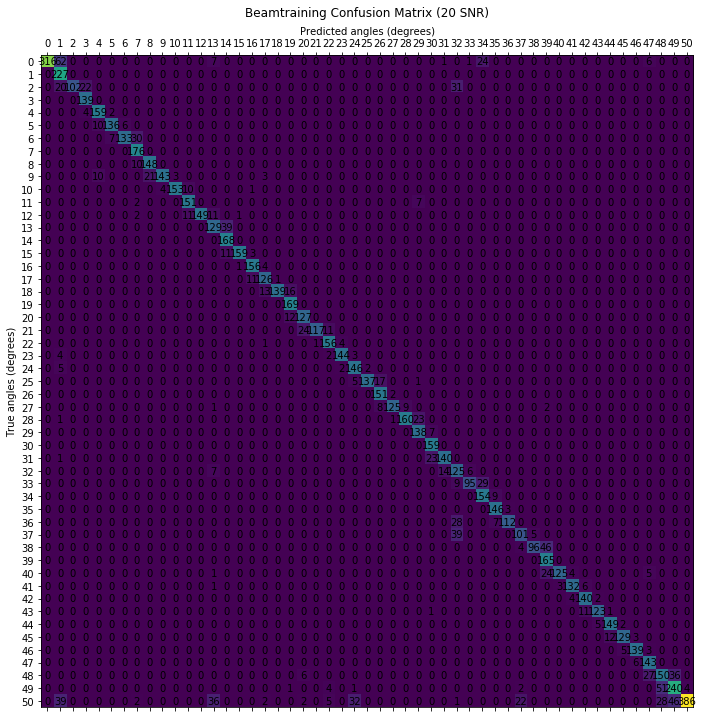

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 50)
8980/8980 - 0s - loss: 0.3728 - sparse_categorical_accuracy: 0.8882
	Test accuracy: 0.888196


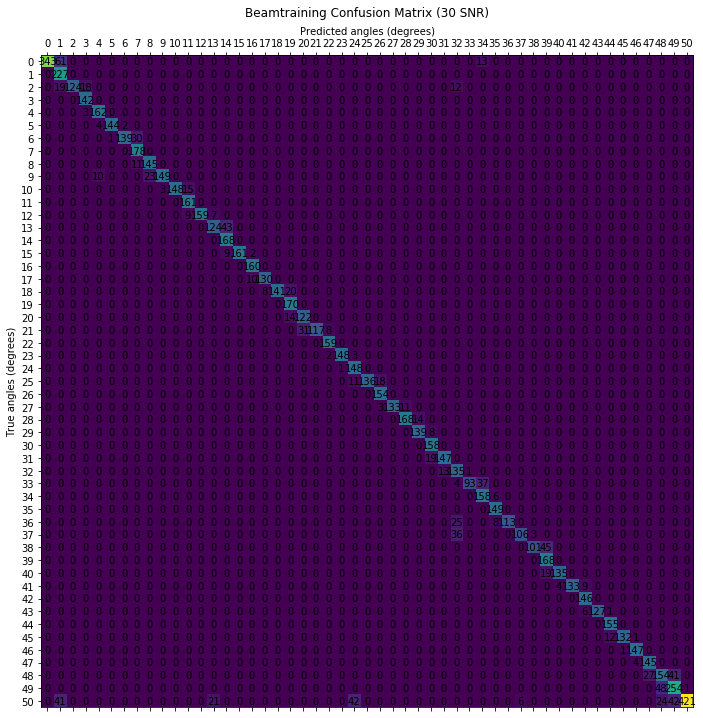

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 50)
17960/17960 - 1s - loss: 0.4267 - sparse_categorical_accuracy: 0.8744
	Test accuracy: 0.8743875


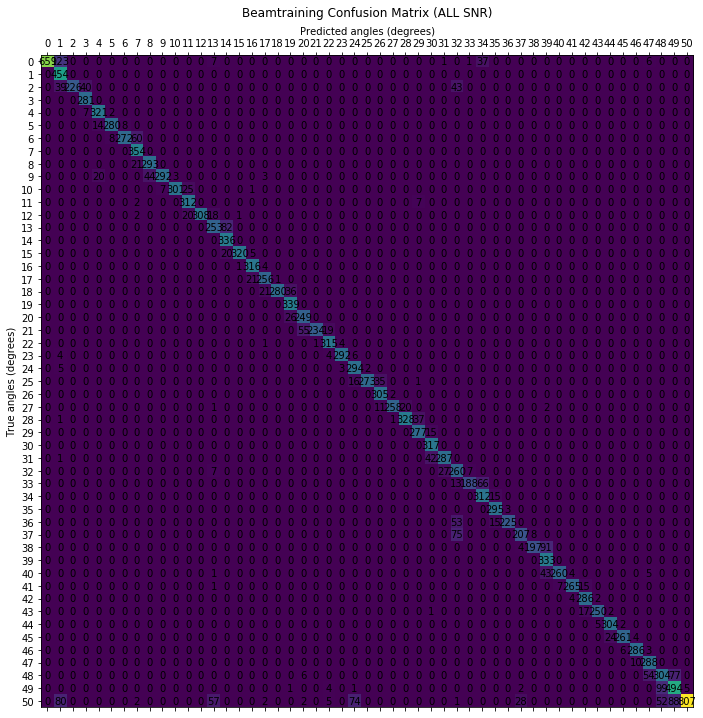


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.294]
 [100.     59.061]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 6.2000e-02]
 [1.0000e+02 6.0019e+01]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.      0.   ]
 [ 10.      0.   ]
 [ 20.      0.   ]
 [ 30.      0.   ]
 [ 40.      0.   ]
 [ 50.      0.   ]
 [ 60.      0.   ]
 [ 70.      0.   ]
 [ 80.      0.   ]
 [ 90.      0.176]
 [100.     60.019]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.86057907342

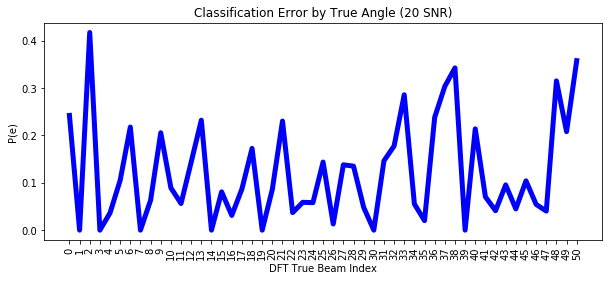

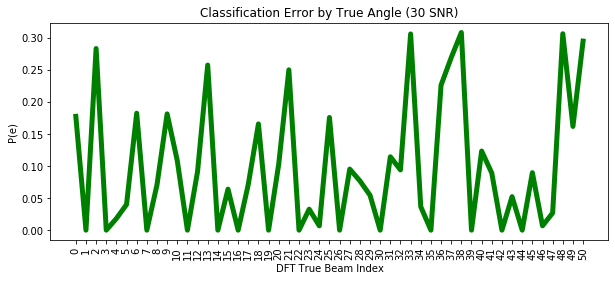

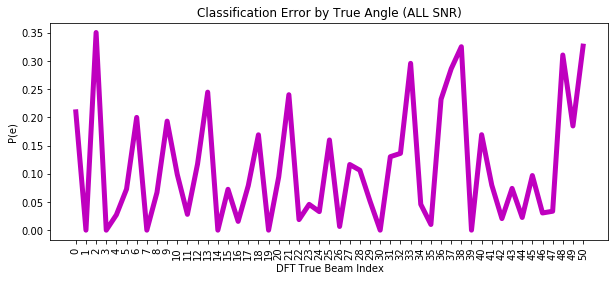

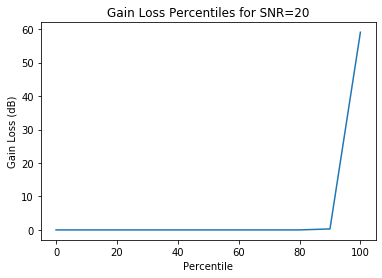

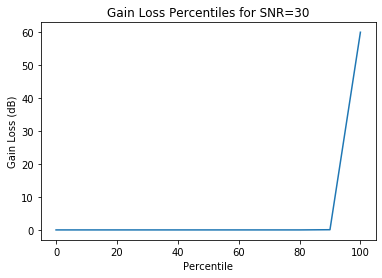

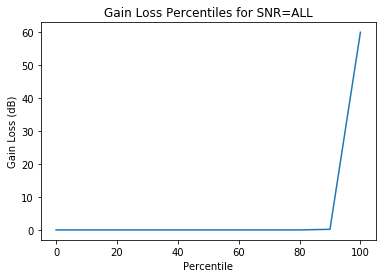

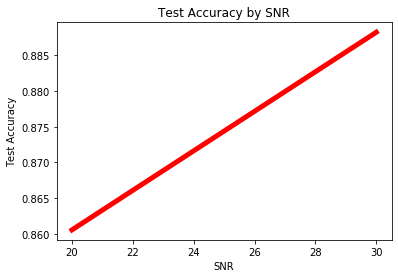

In [35]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 6 Measurements


Training model for PN combo 0...
Train on 680 samples
Epoch 1/75
680/680 [==============================] - 1s 2ms/sample - loss: 1.3568 - sparse_categorical_accuracy: 0.5926
Epoch 2/75
680/680 [==============================] - 0s 584us/sample - loss: 0.7298 - sparse_categorical_accuracy: 0.7603
Epoch 3/75
680/680 [==============================] - 0s 522us/sample - loss: 0.6582 - sparse_categorical_accuracy: 0.7632
Epoch 4/75
680/680 [==============================] - 0s 527us/sample - loss: 0.5989 - sparse_categorical_accuracy: 0.7765
Epoch 5/75
680/680 [==============================] - 0s 531us/sample - loss: 0.5606 - sparse_categorical_accuracy: 0.8074
Epoch 6/75
680/680 [==============================] - 0s 522us/sample - loss: 0.5506 - sparse_categorical_accuracy: 0.8118
Epoch 7/75
680/680 [==============================] - 0s 518us/sample - loss: 0.5079 - sparse_categorical_accuracy: 0.8118
Epoch 8/75
680/680 [==============================] - 0s 519us/sample - loss: 0.5071 -

Text(0.5, 0, 'Epoch')

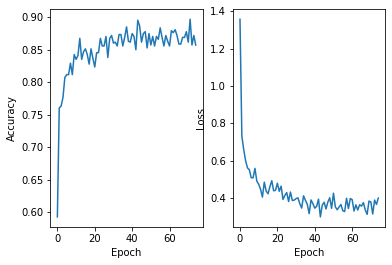

In [12]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(9660, 17)
	labels:      (0, 16)
	predictions: (0, 16)
9660/9660 - 0s - loss: 0.3412 - sparse_categorical_accuracy: 0.8706
	Test accuracy: 0.8706004


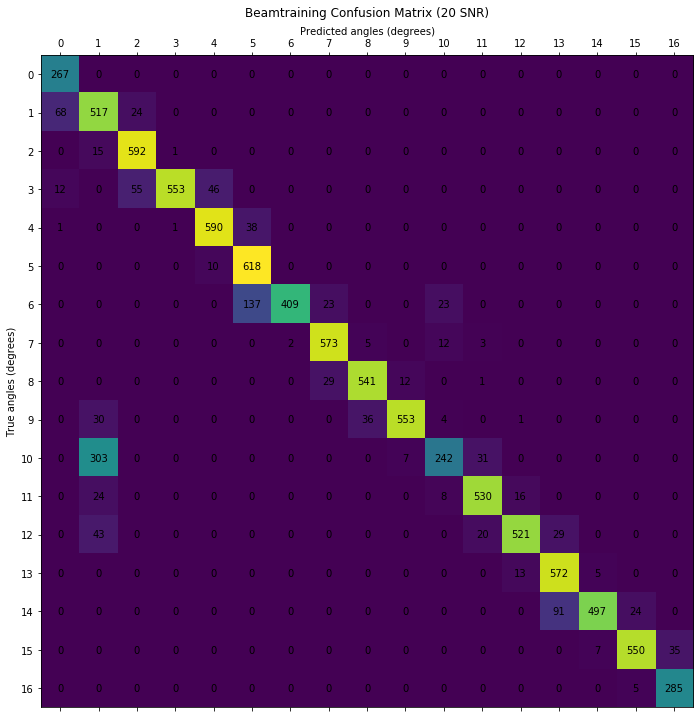

30 dB SNR --
(9660, 17)
	labels:      (0, 16)
	predictions: (0, 16)
9660/9660 - 0s - loss: 0.2540 - sparse_categorical_accuracy: 0.8958
	Test accuracy: 0.8957557


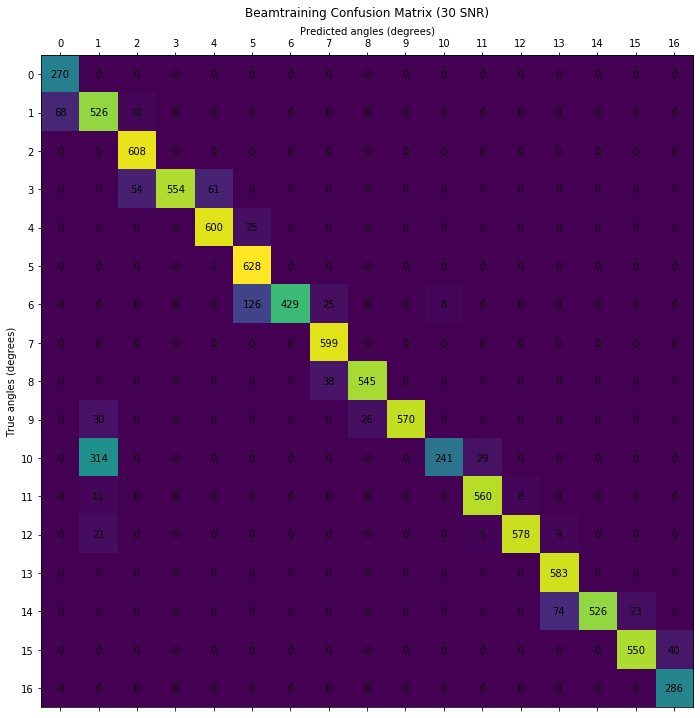

ALL SNR values --
(19320, 17)
	labels:      (0, 16)
	predictions: (0, 16)
19320/19320 - 1s - loss: 0.2976 - sparse_categorical_accuracy: 0.8832
	Test accuracy: 0.88317806


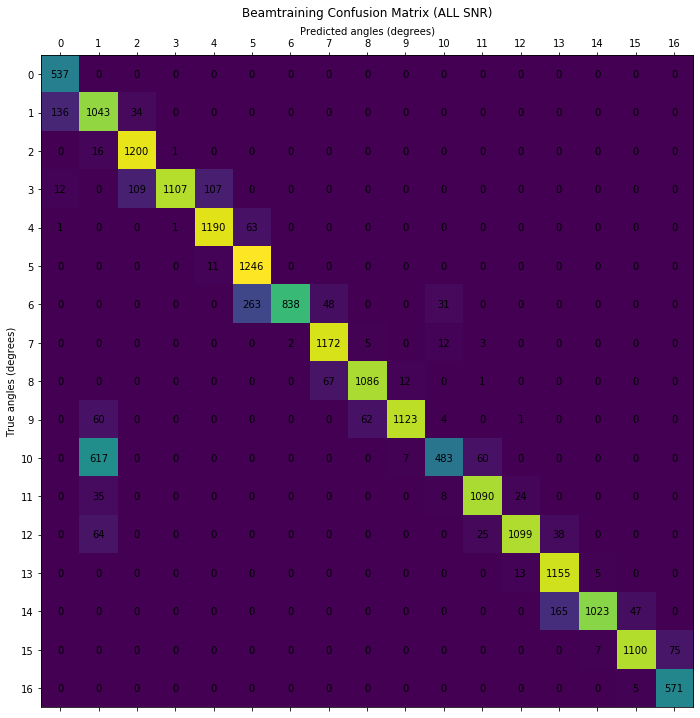


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 17, 17)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.    ]
 [ 80.       0.    ]
 [ 90.       0.2361]
 [100.      37.3616]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[0.000e+00 0.000e+00]
 [1.000e+01 0.000e+00]
 [2.000e+01 0.000e+00]
 [3.000e+01 0.000e+00]
 [4.000e+01 0.000e+00]
 [5.000e+01 0.000e+00]
 [6.000e+01 0.000e+00]
 [7.000e+01 0.000e+00]
 [8.000e+01 0.000e+00]
 [9.000e+01 2.650e-02]
 [1.000e+02 2.428e+01]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.    ]
 [ 80.       0.    ]
 [ 90.       0.1168]
 [100.      37.3616]]

Average Test Accuracies: 
	SNR: 20; A

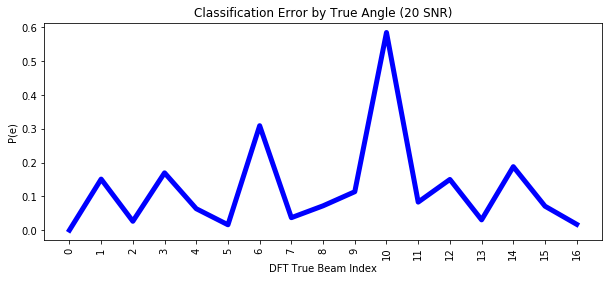

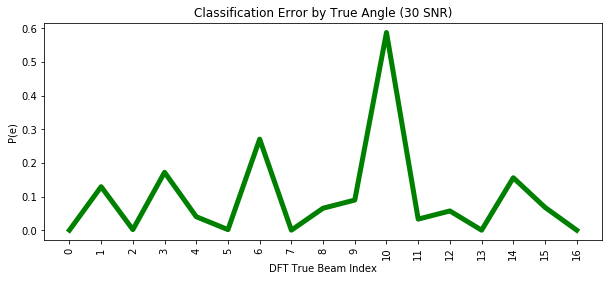

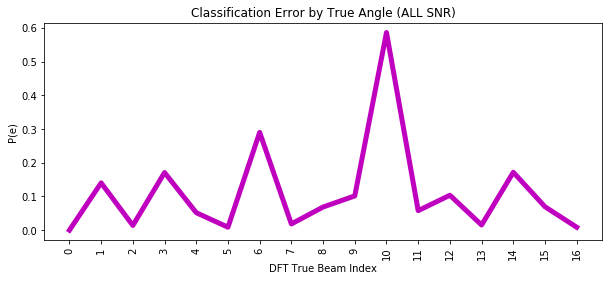

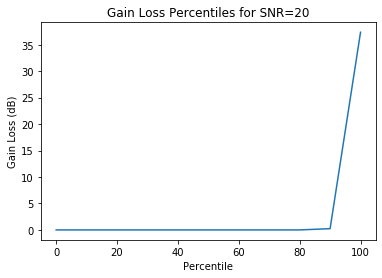

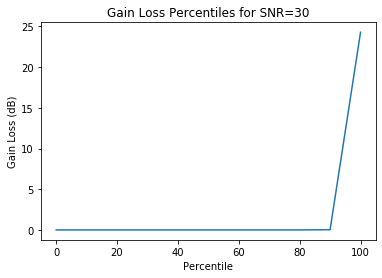

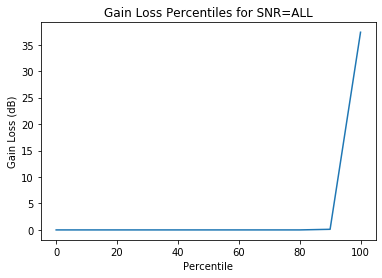

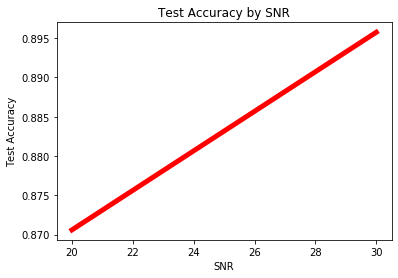

In [16]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 5 Measurements


Training model for PN combo 0...
Train on 6800 samples
Epoch 1/75
6800/6800 [==============================] - 4s 549us/sample - loss: 0.8550 - sparse_categorical_accuracy: 0.7025
Epoch 2/75
6800/6800 [==============================] - 3s 458us/sample - loss: 0.6478 - sparse_categorical_accuracy: 0.7731
Epoch 3/75
6800/6800 [==============================] - 3s 457us/sample - loss: 0.5650 - sparse_categorical_accuracy: 0.7990
Epoch 4/75
6800/6800 [==============================] - 3s 458us/sample - loss: 0.5474 - sparse_categorical_accuracy: 0.8006
Epoch 5/75
6800/6800 [==============================] - 3s 468us/sample - loss: 0.5073 - sparse_categorical_accuracy: 0.8157
Epoch 6/75
6800/6800 [==============================] - 3s 467us/sample - loss: 0.4875 - sparse_categorical_accuracy: 0.8243
Epoch 7/75
6800/6800 [==============================] - 3s 460us/sample - loss: 0.4766 - sparse_categorical_accuracy: 0.8316
Epoch 8/75
6800/6800 [==============================] - 3s 457us/samp

Text(0.5, 0, 'Epoch')

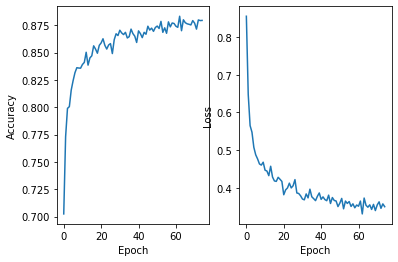

In [23]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(6600, 17)
	labels:      (0, 16)
	predictions: (0, 16)
6600/6600 - 0s - loss: 0.4413 - sparse_categorical_accuracy: 0.8435
	Test accuracy: 0.8434848


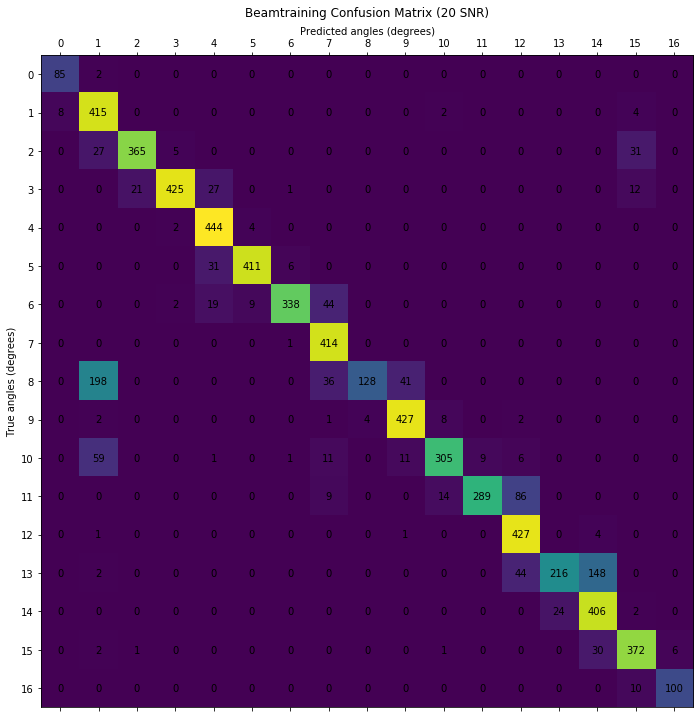

30 dB SNR --
(6600, 17)
	labels:      (0, 16)
	predictions: (0, 16)
6600/6600 - 0s - loss: 0.3074 - sparse_categorical_accuracy: 0.8895
	Test accuracy: 0.88954544


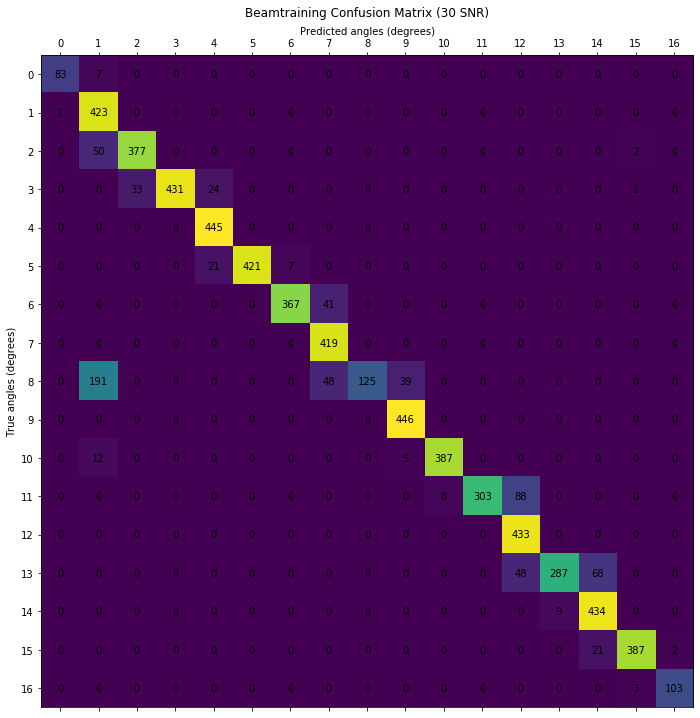

ALL SNR values --
(13200, 17)
	labels:      (0, 16)
	predictions: (0, 16)
13200/13200 - 1s - loss: 0.3744 - sparse_categorical_accuracy: 0.8665
	Test accuracy: 0.86651516


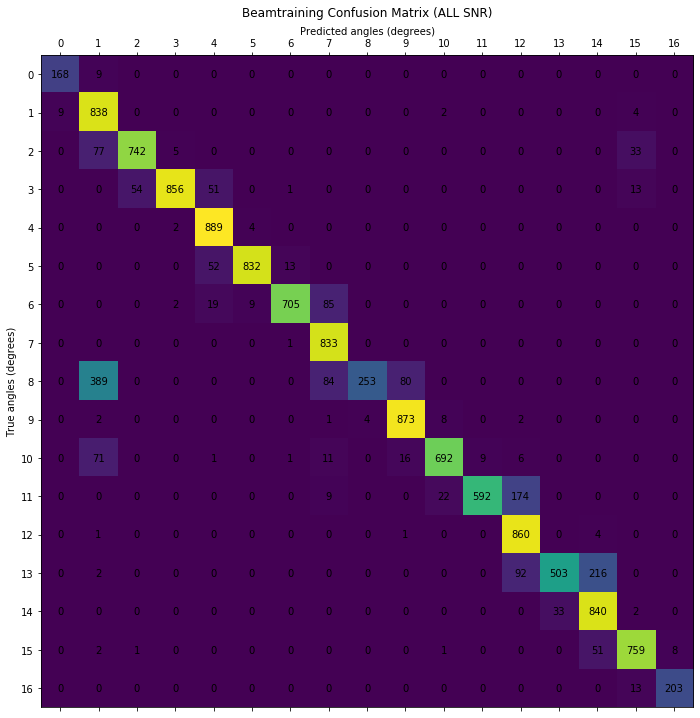


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 17, 17)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.    ]
 [ 80.       0.    ]
 [ 90.       0.6174]
 [100.      49.15  ]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[0.0000e+00 0.0000e+00]
 [1.0000e+01 0.0000e+00]
 [2.0000e+01 0.0000e+00]
 [3.0000e+01 0.0000e+00]
 [4.0000e+01 0.0000e+00]
 [5.0000e+01 0.0000e+00]
 [6.0000e+01 0.0000e+00]
 [7.0000e+01 0.0000e+00]
 [8.0000e+01 0.0000e+00]
 [9.0000e+01 7.2700e-02]
 [1.0000e+02 2.9675e+01]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.    ]
 [ 50.       0.    ]
 [ 60.       0.    ]
 [ 70.       0.    ]
 [ 80.       0.    ]
 [ 90.       0.2949]
 [100.      49.15  ]]

Average Test Ac

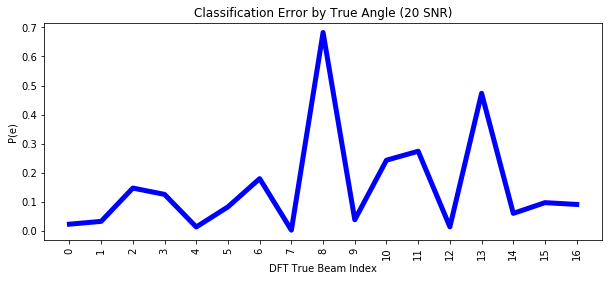

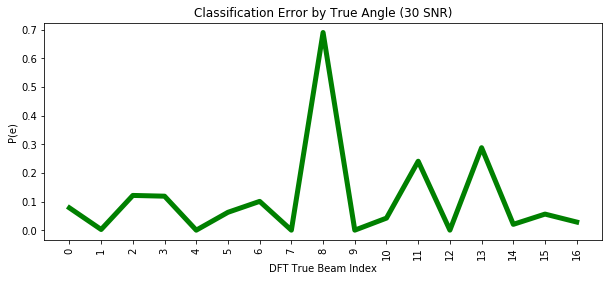

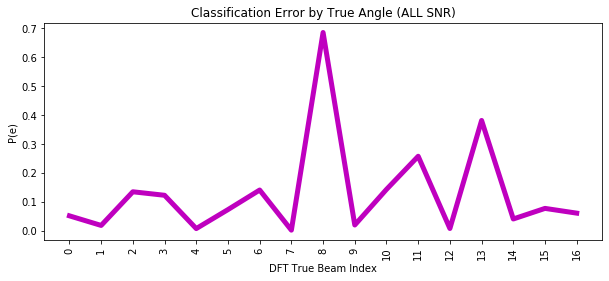

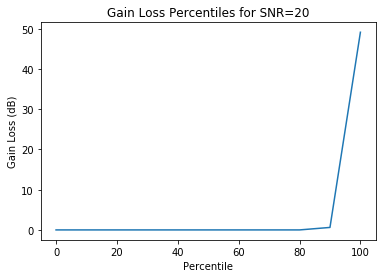

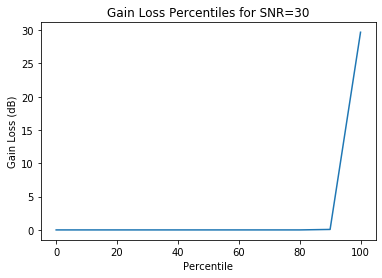

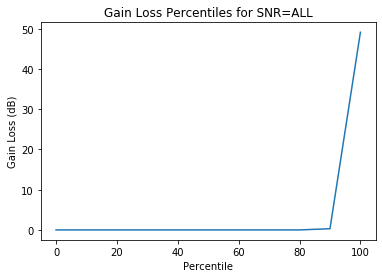

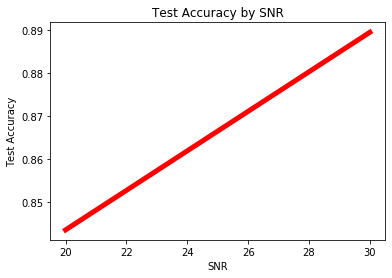

In [24]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 4 Measurements


Training model for PN combo 0...
Train on 6800 samples
Epoch 1/75
6800/6800 [==============================] - 5s 701us/sample - loss: 1.1863 - sparse_categorical_accuracy: 0.5921
Epoch 2/75
6800/6800 [==============================] - 4s 580us/sample - loss: 0.9137 - sparse_categorical_accuracy: 0.6832
Epoch 3/75
6800/6800 [==============================] - 4s 586us/sample - loss: 0.8546 - sparse_categorical_accuracy: 0.7013
Epoch 4/75
6800/6800 [==============================] - 4s 577us/sample - loss: 0.8005 - sparse_categorical_accuracy: 0.7215
Epoch 5/75
6800/6800 [==============================] - 4s 580us/sample - loss: 0.7849 - sparse_categorical_accuracy: 0.7251
Epoch 6/75
6800/6800 [==============================] - 4s 584us/sample - loss: 0.7637 - sparse_categorical_accuracy: 0.7294
Epoch 7/75
6800/6800 [==============================] - 4s 588us/sample - loss: 0.7288 - sparse_categorical_accuracy: 0.7432
Epoch 8/75
6800/6800 [==============================] - 4s 576us/samp

Text(0.5, 0, 'Epoch')

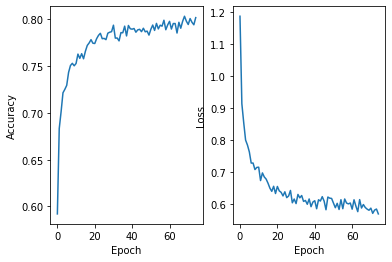

In [27]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

In [ ]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 3 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.3881 - sparse_categorical_accuracy: 0.1206
Epoch 2/75
2040/2040 [==============================] - 2s 837us/sample - loss: 3.2793 - sparse_categorical_accuracy: 0.1426
Epoch 3/75
2040/2040 [==============================] - 2s 776us/sample - loss: 3.1949 - sparse_categorical_accuracy: 0.1647
Epoch 4/75
2040/2040 [==============================] - 2s 749us/sample - loss: 3.1049 - sparse_categorical_accuracy: 0.1941
Epoch 5/75
2040/2040 [==============================] - 2s 752us/sample - loss: 3.0133 - sparse_categorical_accuracy: 0.2186
Epoch 6/75
2040/2040 [==============================] - 2s 754us/sample - loss: 3.0025 - sparse_categorical_accuracy: 0.2147
Epoch 7/75
2040/2040 [==============================] - 2s 751us/sample - loss: 2.9251 - sparse_categorical_accuracy: 0.2304
Epoch 8/75
2040/2040 [==============================] - 2s 753us/sample

Text(0.5, 0, 'Epoch')

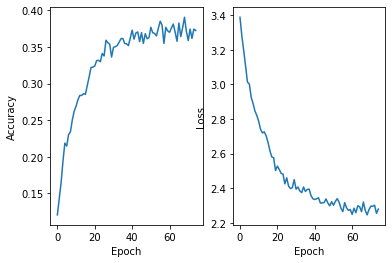

In [50]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (1, 50)
8980/8980 - 0s - loss: 4.0557 - sparse_categorical_accuracy: 0.3430
	Test accuracy: 0.3429844


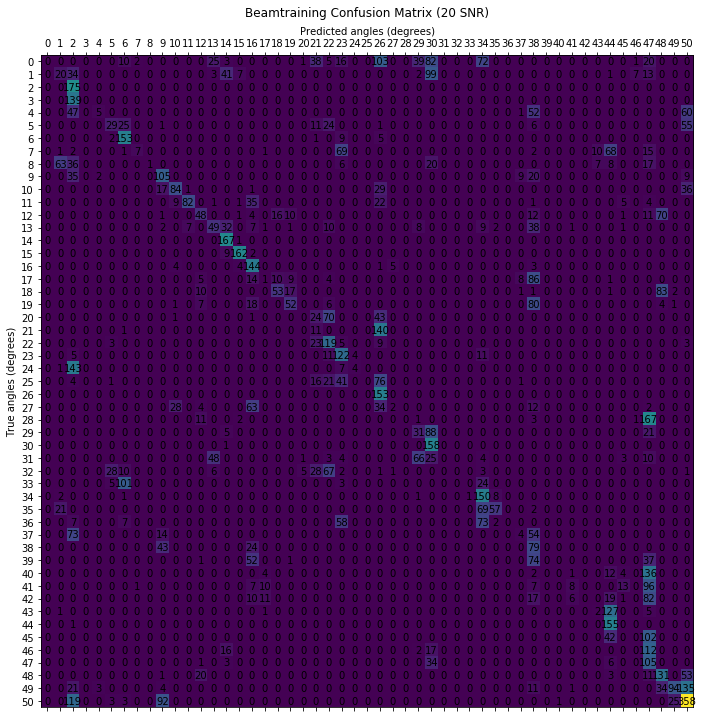

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (1, 50)
8980/8980 - 0s - loss: 3.4682 - sparse_categorical_accuracy: 0.3693
	Test accuracy: 0.36926502


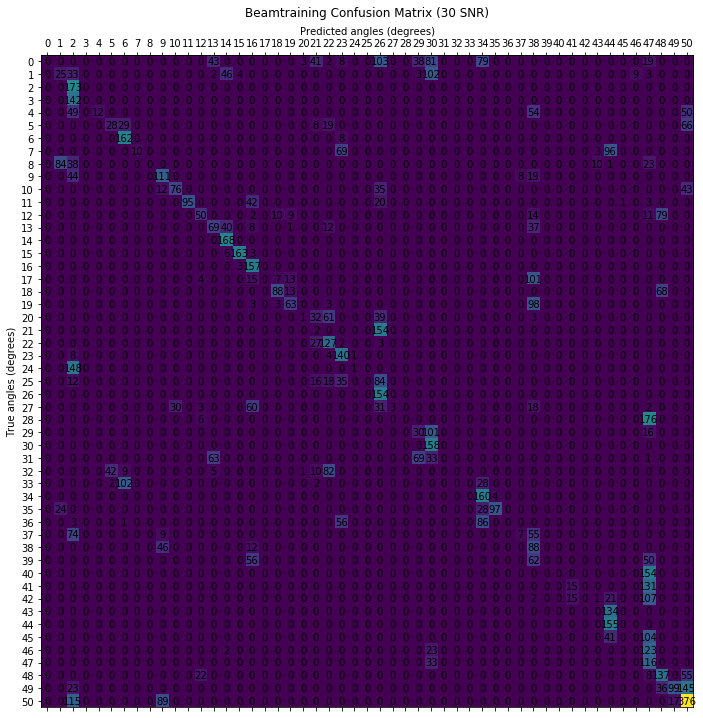

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (1, 50)
17960/17960 - 1s - loss: 3.7619 - sparse_categorical_accuracy: 0.3561
	Test accuracy: 0.35612473


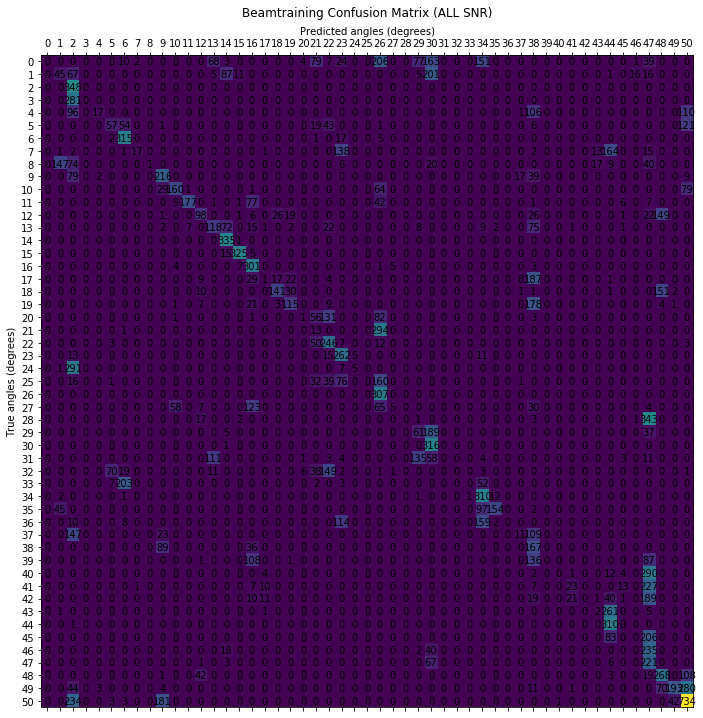


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.935 ]
 [ 50.       7.7699]
 [ 60.      19.3094]
 [ 70.      26.487 ]
 [ 80.      29.866 ]
 [ 90.      33.951 ]
 [100.      66.067 ]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.461 ]
 [ 50.       4.22  ]
 [ 60.      18.6198]
 [ 70.      26.89  ]
 [ 80.      30.399 ]
 [ 90.      34.026 ]
 [100.      76.606 ]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.       0.    ]
 [ 10.       0.    ]
 [ 20.       0.    ]
 [ 30.       0.    ]
 [ 40.       0.68  ]
 [ 50.       5.8323]
 [ 60.      19.0044]
 [ 70.      26.662 ]
 [ 80.      30.173 ]
 [ 90.      33.983 ]
 [100.      76.606 ]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.34298440814

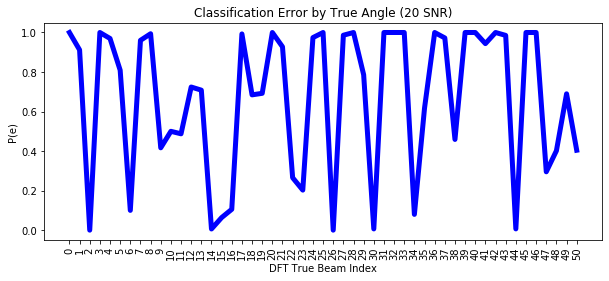

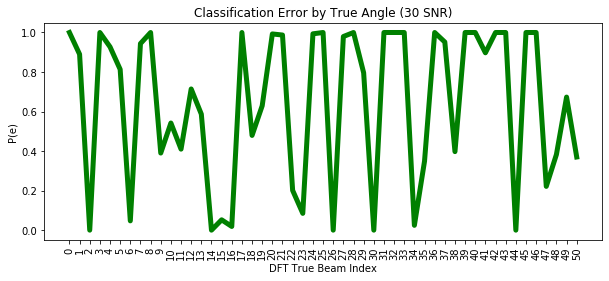

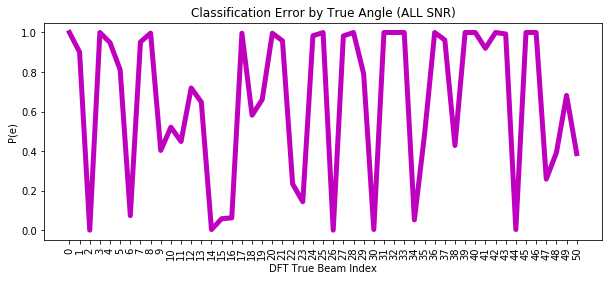

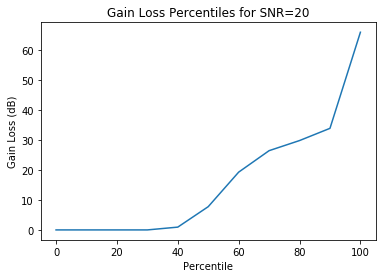

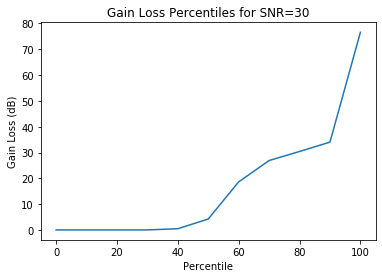

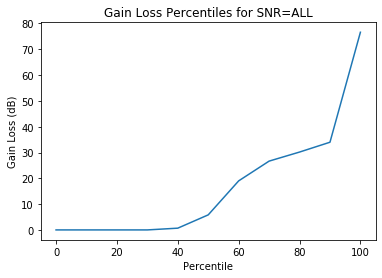

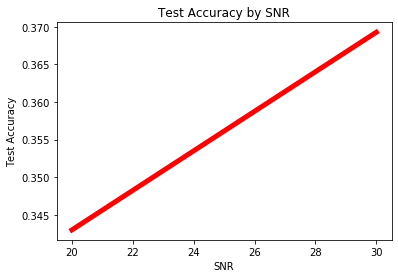

In [51]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

### NN for 2 Measurements


Training model for PN combo 0...
Train on 2040 samples
Epoch 1/75
2040/2040 [==============================] - 3s 1ms/sample - loss: 3.7169 - sparse_categorical_accuracy: 0.0583
Epoch 2/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6791 - sparse_categorical_accuracy: 0.0804
Epoch 3/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6730 - sparse_categorical_accuracy: 0.0824
Epoch 4/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6773 - sparse_categorical_accuracy: 0.0814
Epoch 5/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6498 - sparse_categorical_accuracy: 0.0897
Epoch 6/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6569 - sparse_categorical_accuracy: 0.0912
Epoch 7/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.6447 - sparse_categorical_accuracy: 0.0858
Epoch 8/75
2040/2040 [==============================] - 2s 1ms/sample - loss: 3.626

Text(0.5, 0, 'Epoch')

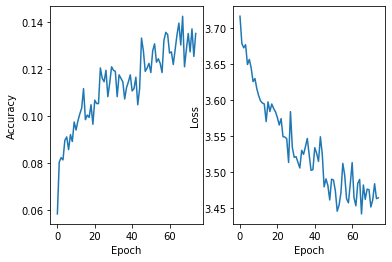

In [54]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Sparse Categorical Cross-Entropy loss function

# Architecture constants
#fc_dims = [64, 64, 128]  # Produced good results, best = 71% test acc
fc_dims = [64, 128]  # Produced best results so far, best = 67-75% test acc
dropout_rate = 0.3
batch_size = NUM_MEAS
num_epochs = 75

# Train a NN with each set of PN beams
all_models = []      # List to save the models (for each PN combo)
all_loss = np.zeros((NUM_PN_COMBO, num_epochs))
all_train_acc = np.zeros((NUM_PN_COMBO, num_epochs))

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nTraining model for PN combo {}...".format(pn_i))
    
    # Actual NN architecture
#     inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
#     fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
#     bn1 = layers.BatchNormalization()(fc1)
#     drp1 = layers.Dropout(dropout_rate)(bn1)
#     fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(drp1)
#     bn2 = layers.BatchNormalization()(fc2)
#     drp2 = layers.Dropout(dropout_rate)(bn2)
#     # fc3 = layers.Dense(fc_dims[2], activation='relu', name='dense_3')(drp2)
#     # bn3 = layers.BatchNormalization()(fc3)
#     # drp3 = layers.Dropout(dropout_rate)(bn3)
#     outputs = layers.Dense(NUM_CLASSES, name='predictions')(drp2)
    
    # Test without dropout
    inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
    fc1 = layers.Dense(fc_dims[0], activation='relu', name='dense_1')(inputs)
    bn1 = layers.BatchNormalization()(fc1)
    #drp1 = layers.Dropout(dropout_rate)(bn1)
    fc2 = layers.Dense(fc_dims[1], activation='relu', name='dense_2')(bn1)
    bn2 = layers.BatchNormalization()(fc2)
    #drp2 = layers.Dropout(dropout_rate)(bn2)
    outputs = layers.Dense(NUM_CLASSES, name='predictions')(bn2)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
                  # Loss function to minimize
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  # List of metrics to monitor
                  metrics=['sparse_categorical_accuracy'])

    # model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
    #               loss='mse',       # mean squared error
    #               metrics=['mae'])  # mean absolute error

    # model.fit(train_data_all, train_labels_all, epochs=10, batch_size=NUM_MEAS,
    #           validation_data=(val_data_all, val_labels_all))
    
    # Train the NN
    loss_hist = model.fit(train_data_all[pn_i], train_classes_all[pn_i], epochs=num_epochs, batch_size=batch_size)
    
    # Save the data to the overall lists
    all_models.append(model)
    all_train_acc[pn_i, :] = loss_hist.history['sparse_categorical_accuracy']
    all_loss[pn_i, :] = loss_hist.history['loss']

# Plot the results
plt.figure()
plt.subplot(1,2,1)
plt.plot(all_train_acc.T)
#plt.plot(loss_hist.history['val_acc'])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(all_loss.T)
#plt.plot(loss_hist.history['val_loss'])
plt.ylabel("Loss")
plt.xlabel("Epoch")
#plt.legend(["Training", "Validation"])


PN combo 0...
20 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 47)
8980/8980 - 0s - loss: 14.5852 - sparse_categorical_accuracy: 0.0687
	Test accuracy: 0.06870824


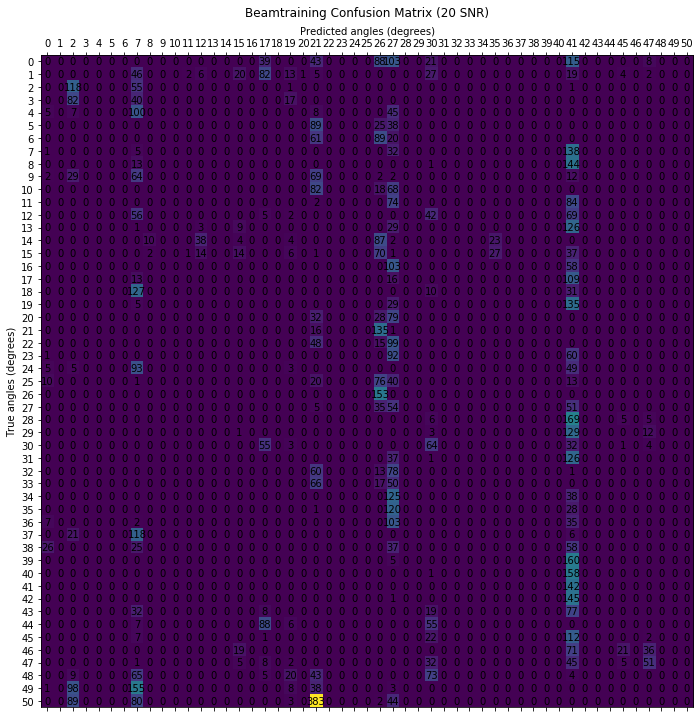

30 dB SNR --
(8980, 51)
	labels:      (0, 50)
	predictions: (0, 47)
8980/8980 - 0s - loss: 13.4404 - sparse_categorical_accuracy: 0.0742
	Test accuracy: 0.07416481


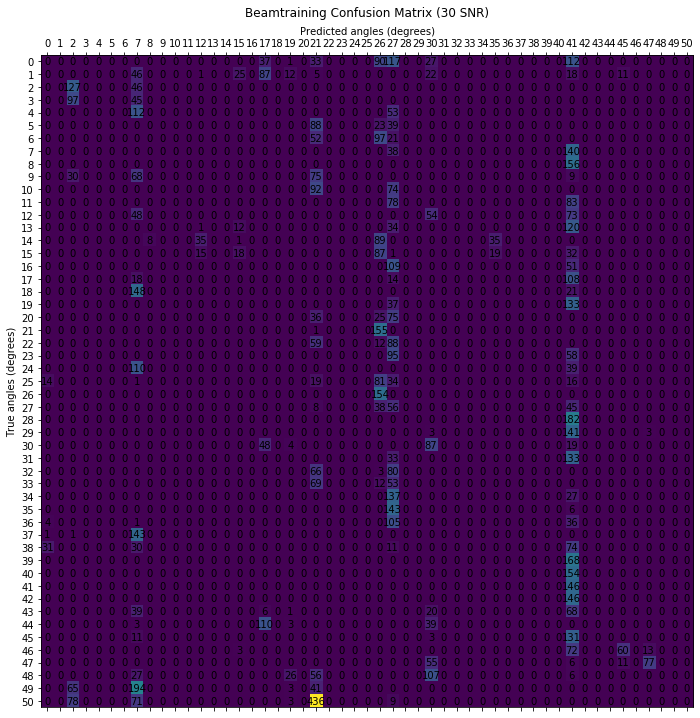

ALL SNR values --
(17960, 51)
	labels:      (0, 50)
	predictions: (0, 47)
17960/17960 - 1s - loss: 14.0128 - sparse_categorical_accuracy: 0.0714
	Test accuracy: 0.071436524


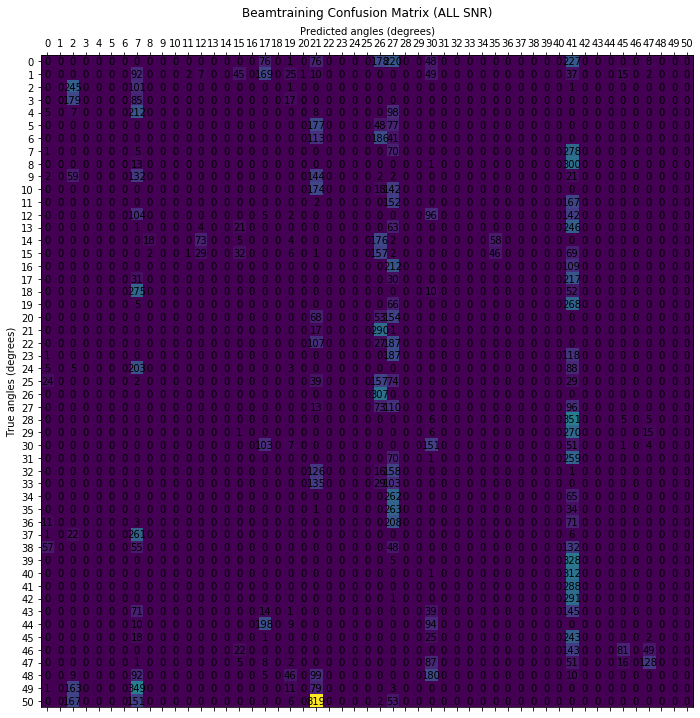


Number of results:            (1, 3)
Confusion matrix tensor size: (1, 3, 51, 51)
20 dB SNR --
30 dB SNR --
20 dB SNR --
Gain Loss Percentiles, SNR 20
[[  0.       0.    ]
 [ 10.       1.672 ]
 [ 20.      14.5244]
 [ 30.      20.4361]
 [ 40.      23.9763]
 [ 50.      26.323 ]
 [ 60.      28.237 ]
 [ 70.      30.197 ]
 [ 80.      32.556 ]
 [ 90.      36.331 ]
 [100.      64.02  ]]
30 dB SNR --
Gain Loss Percentiles, SNR 30
[[  0.       0.    ]
 [ 10.       1.283 ]
 [ 20.      13.7852]
 [ 30.      20.5804]
 [ 40.      24.5212]
 [ 50.      27.32  ]
 [ 60.      29.225 ]
 [ 70.      30.984 ]
 [ 80.      33.353 ]
 [ 90.      37.898 ]
 [100.      69.978 ]]
ALL SNR values --
Gain Loss Percentiles, SNR ALL
[[  0.       0.    ]
 [ 10.       1.456 ]
 [ 20.      14.1747]
 [ 30.      20.5078]
 [ 40.      24.2721]
 [ 50.      26.8098]
 [ 60.      28.756 ]
 [ 70.      30.634 ]
 [ 80.      32.976 ]
 [ 90.      37.032 ]
 [100.      69.978 ]]

Average Test Accuracies: 
	SNR: 20; Accuracy: 0.06870824098

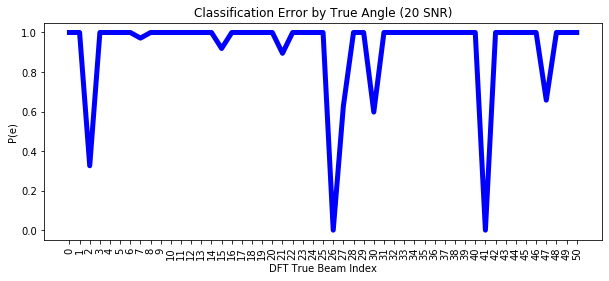

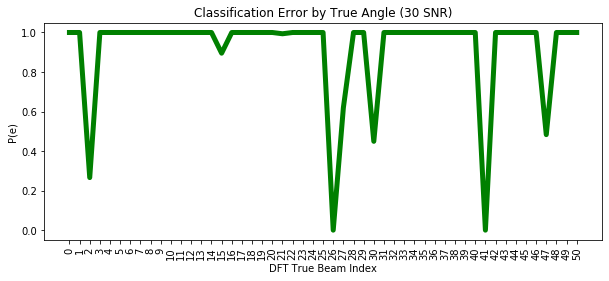

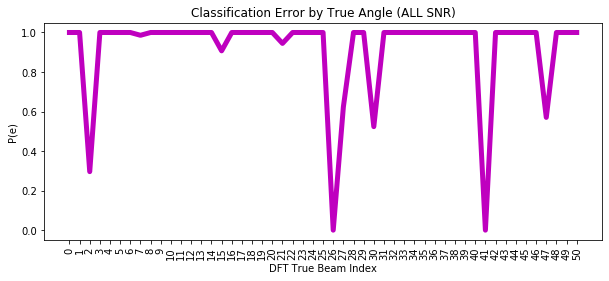

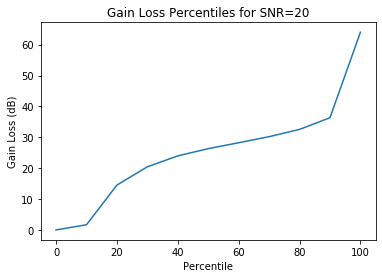

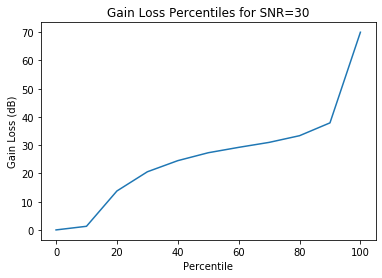

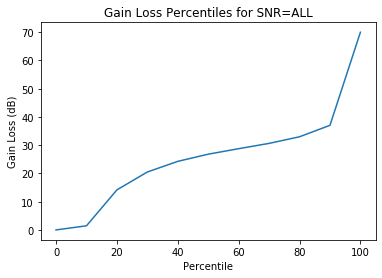

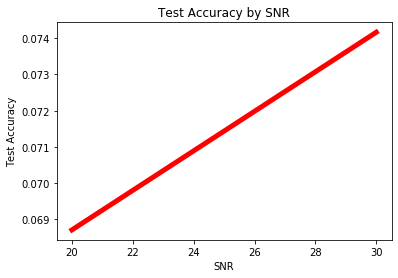

In [55]:
### Test the NN Model ###
all_curMeas_acc = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1))         ####################
all_curMeas_test_confusion = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES, NUM_CLASSES))
all_curMeas_pe = np.zeros((NUM_PN_COMBO, len(DATA_SNR)+1, NUM_CLASSES))
all_curMeas_gainloss = {}   # Format: {pn_i}{SNR_i}[test_trial] ({} = dict, [] = np array) 

for pn_i in np.arange(NUM_PN_COMBO):
    print("\nPN combo {}...".format(pn_i))
    pn_i_gainloss = {} 
    
    for snr_ind in np.arange(len(DATA_SNR)+1):         ####################
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
            print("{} dB SNR --".format(SNR_i))
        else:
            SNR_i = 'ALL'
            print("ALL SNR values --")
#     for snr_ind in np.arange(len(DATA_SNR)):
#         SNR_i = DATA_SNR[snr_ind]
#         print("{} dB SNR --".format(SNR_i))
        test_predictions = all_models[pn_i].predict(test_data_dict[SNR_i][pn_i])
        print(test_predictions.shape)
        print('\tlabels:      ({}, {})'.format(np.min(test_classes_dict[SNR_i][pn_i]), np.max(test_classes_dict[SNR_i][pn_i])))
        print('\tpredictions: ({}, {})'.format(np.min(np.argmax(test_predictions, 1)), np.max(np.argmax(test_predictions, 1))))
        #print(val_labels[item,:])

        test_loss, test_acc = all_models[pn_i].evaluate(test_data_dict[SNR_i][pn_i],  test_classes_dict[SNR_i][pn_i], verbose=2)
        print('\tTest accuracy:', test_acc)
        class_test_acc[SNR_i] = test_acc

        # Compute the predicted labels and the confusion matrix
        test_pred_classes = np.argmax(test_predictions, 1)
        test_confusion = tf.math.confusion_matrix(test_classes_dict[SNR_i][pn_i],
                                                  test_pred_classes)
        #print(test_confusion)
        class_confusionMat[SNR_i] = test_confusion
        CLASSES = dft_use

        ## Plot the confusion matrix (see which beams get associated with each other)
        fig, ax = plt.subplots()
        ax.matshow(test_confusion)
        for (i, j), z in np.ndenumerate(test_confusion):
            ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

        ax.set_xticklabels(CLASSES)
        ax.set_yticklabels(CLASSES)
        ax.xaxis.set_label_position("top")
        fig.set_size_inches(12, 12)
        plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
        plt.xlabel("Predicted angles (degrees)")
        plt.ylabel("True angles (degrees)")
        plt.xticks(np.arange(NUM_CLASSES))
        plt.yticks(np.arange(NUM_CLASSES))
        plt.savefig('../figures/confusionMatrix_sim{}_{}meas_{}SNR.png'.format(NN_NUM, NUM_MEAS, SNR_i))
        plt.show()

        ## Plot the P(e) given a specific angle
        num_true_angles = np.sum(test_confusion,1)
        num_correct = np.diag(test_confusion)
        num_incorrect = num_true_angles - num_correct
        pe = num_incorrect/num_true_angles

        ## Compute the gain loss for each test beam
        label_dft_ind = dft_use[test_classes_dict[SNR_i][pn_i]].flatten()
        max_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(label_dft_ind)), label_dft_ind]
        selected_dft_ind = dft_use[test_pred_classes]
        achieved_gain = dft_rssi_dict[SNR_i][pn_i][np.arange(len(selected_dft_ind)), selected_dft_ind]
        pn_i_gainloss[SNR_i] = max_gain - achieved_gain

        ## Store the results for a final overall plot
        all_curMeas_acc[pn_i, snr_ind] = test_acc
        all_curMeas_test_confusion[pn_i, snr_ind, :, :] = test_confusion
        all_curMeas_pe[pn_i, snr_ind, :] = pe

    ## Store the gain loss dictionary for this PN beam combo
    all_curMeas_gainloss[pn_i] = pn_i_gainloss
        
## Post-process the results and combine for plots
print("\nNumber of results:            {}".format(all_curMeas_acc.shape))
print("Confusion matrix tensor size: {}".format(all_curMeas_test_confusion.shape))

# Plot the P(e) by DFT label for each SNR         ####################
colors_snr = ['b', 'g', 'm', 'c', 'r']
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.plot(np.arange(NUM_CLASSES), all_curMeas_pe[:,snr_ind,:].T, color=colors_snr[snr_ind], linewidth=0.5)
    plt.plot(np.arange(NUM_CLASSES), np.mean(all_curMeas_pe, 0)[snr_ind], color=colors_snr[snr_ind], linewidth=5)
    plt.title("Classification Error by True Angle ({} SNR)".format(SNR_i))
    plt.xlabel("DFT True Beam Index")
    plt.ylabel("P(e)")
    plt.xticks(np.arange(NUM_CLASSES), CLASSES, rotation=90);

# Plot the gain loss peformance
all_gainloss_perc = np.zeros((len(DATA_SNR)+1, NUM_PN_COMBO, len(GAIN_LOSS_PERCENTILES)))         ####################
for snr_ind in np.arange(len(DATA_SNR)+1):
    if snr_ind != len(DATA_SNR):
        SNR_i = DATA_SNR[snr_ind]
        print("{} dB SNR --".format(SNR_i))
    else:
        SNR_i = 'ALL'
        print("ALL SNR values --")
#     SNR_i = DATA_SNR[snr_ind]
    for pn_i in np.arange(NUM_PN_COMBO):
        all_gainloss_perc[snr_ind, pn_i, :] = np.percentile(all_curMeas_gainloss[pn_i][SNR_i], GAIN_LOSS_PERCENTILES, interpolation='lower')
    # Plot the results
    fig = plt.figure()
    plt.plot(GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :].T)
    fig.set_size_inches(6, 4)
    plt.title("Gain Loss Percentiles for SNR={}".format(SNR_i))
    plt.xlabel("Percentile")
    plt.ylabel("Gain Loss (dB)")
    print("Gain Loss Percentiles, SNR {}".format(SNR_i))
    print(np.vstack((GAIN_LOSS_PERCENTILES, all_gainloss_perc[snr_ind, :, :])).T)
    
# Plot the test accuracy vs SNR (each PN beam combo and the overall averages)
avg_acc_snr = np.mean(all_curMeas_acc, 0)
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(DATA_SNR, all_curMeas_acc[:, np.arange(len(DATA_SNR))].T)                 # Plot all the PN beam combos         ####################
plt.plot(DATA_SNR, avg_acc_snr[np.arange(len(DATA_SNR))], color='r', linewidth=5)  # Plot the average per SNR
plt.title("Test Accuracy by SNR")
plt.xlabel("SNR")
plt.ylabel("Test Accuracy")

print("\nAverage Test Accuracies: ")
for snr_ind in np.arange(len(DATA_SNR)):
    print("\tSNR: {}; Accuracy: {}".format(DATA_SNR[snr_ind], avg_acc_snr[snr_ind]))

# Save the results for this number of measurements to the overall dictionaries
all_test_acc[NUM_MEAS] = all_curMeas_acc
all_confusionMat[NUM_MEAS] = all_curMeas_test_confusion
all_pe_byLabel[NUM_MEAS] = all_curMeas_pe
all_gainLoss[NUM_MEAS] = all_gainloss_perc

# Overall Results Plots

In [56]:
# Check that all M values were tested
print(len(all_gainLoss))
print(all_gainLoss.keys())
#print(all_gainLoss[2][2,0,:])
#print(len(GAIN_LOSS_PERCENTILES))

13
dict_keys([36, 20, 15, 12, 10, 9, 8, 7, 6, 5, 4, 3, 2])


In [57]:
## Save total results to a pickle file
import pickle

## See how many results are available
print(len(all_test_acc))
print(len(all_confusionMat))
print(len(all_pe_byLabel))
print(len(all_gainLoss))

print(all_test_acc.keys())
print(all_test_acc[2])

## Save to a pickle file
return # ONLY RUN IF YOU WANT TO OVERWRITE THE RESULTS SAVED
#TODO: SAVE ALL GAIN LOSS PERCENTILES AND MODELS TO AN OVERALL DICTIONARY
with open('all_NN_sim2_results.pkl', 'wb') as f:
    pickle.dump([all_test_acc, all_confusionMat, all_pe_byLabel, all_gainLoss], f)
    #TODO: ADD MORE VARS

13
13
13
13
dict_keys([36, 20, 15, 12, 10, 9, 8, 7, 6, 5, 4, 3, 2])
[[0.06870824 0.07416481 0.07143652]]


In [ ]:
## Load the pickle file
return # ONLY RUN IF YOU WANT TO OVERWRITE THE RESULTS CAPTURED
with open('all_NN_sim2_results.pkl', 'rb') as f:
    all_test_acc, all_confusionMat, all_pe_byLabel, all_gainLoss = pickle.load(f)

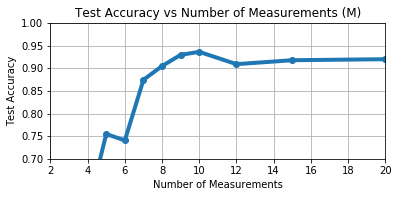

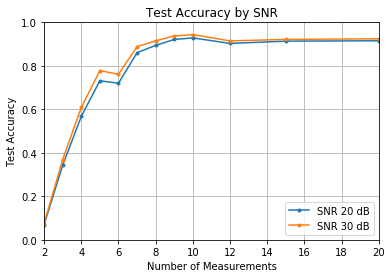

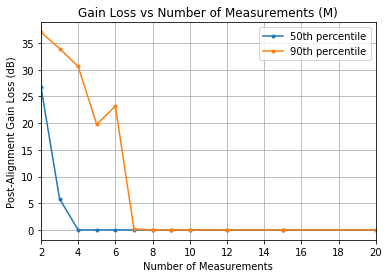

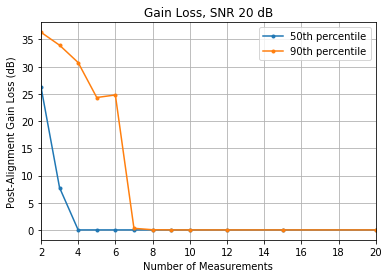

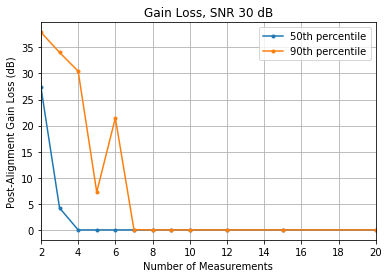

In [58]:
### Plot the overall results for the testing with all SNRs
included_num_meas = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20])
plot_test_acc_allsnr = np.zeros((len(DATA_SNR)+1, len(included_num_meas)))

# Averaged over all PN beam combos
for m_i in np.arange(len(included_num_meas)):
    for snr_ind in np.arange(len(DATA_SNR)+1):
        if snr_ind != len(DATA_SNR):
            SNR_i = DATA_SNR[snr_ind]
        else:
            SNR_i = 'ALL'
        temp_test_acc = all_test_acc[included_num_meas[m_i]]
        plot_test_acc_allsnr[snr_ind, m_i] = np.mean(temp_test_acc[:, snr_ind])

# Plot the result
# Plot of accuracy testing all SNRs together
fig = plt.figure()
plt.plot(included_num_meas, plot_test_acc_allsnr[len(DATA_SNR), :], marker="o", lw=4)
plt.title("Test Accuracy vs Number of Measurements (M)")
plt.xlabel("Number of Measurements")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.ylim(0.7, 1)
plt.yticks(np.arange(70, 105, 5)/100)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))
fig.set_size_inches(6, 2.5)
plt.savefig("../figures/nn_acc_allSNR_sim2.png")

# Plot of accuracy vs each SNR
plt.figure()
plt.plot(included_num_meas, plot_test_acc_allsnr[np.arange(len(DATA_SNR)), :].T, marker=".")
plt.title("Test Accuracy by SNR")
plt.xlabel("Number of Measurements")
plt.ylabel("Test Accuracy")
plt.legend(("SNR {} dB".format(DATA_SNR[0]), "SNR {} dB".format(DATA_SNR[1])))
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))

# Extract all the gain loss statistics
percentile_indices = np.array([5, 9]) # indices correspond to 0:10:100 (i.e. 5 -> 50%)
plot_all_gainLoss = np.zeros((len(included_num_meas), len(DATA_SNR)+1, len(GAIN_LOSS_PERCENTILES)))
for snr_ind in np.arange(len(DATA_SNR)+1):
    for m_i in np.arange(len(included_num_meas)):
        plot_all_gainLoss[m_i, snr_ind, :] = all_gainLoss[included_num_meas[m_i]][snr_ind, 0, :]

# Plot of 50th and 90th percentile gain loss testing all SNRs together
plt.figure()
plt.plot(included_num_meas, plot_all_gainLoss[:, len(DATA_SNR), percentile_indices], marker=".")
plt.title("Gain Loss vs Number of Measurements (M)")
plt.xlabel("Number of Measurements")
plt.ylabel("Post-Alignment Gain Loss (dB)")
plt.grid(True)
plt.xlim(np.min(included_num_meas),np.max(included_num_meas))
#fig.set_size_inches(6, 2.5)
plt.legend(("{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[0]]), "{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[1]])))
plt.savefig("../figures/nn_gainLoss_allSNR_sim2.png")

# Plot of gain loss vs each SNR
for plot_snr_ind in np.arange(len(DATA_SNR)):
    plt.figure()
    plt.plot(included_num_meas, plot_all_gainLoss[:, plot_snr_ind, percentile_indices], marker=".")
    plt.title("Gain Loss, SNR {} dB".format(DATA_SNR[plot_snr_ind]))
    plt.xlabel("Number of Measurements")
    plt.ylabel("Post-Alignment Gain Loss (dB)")
    plt.legend(("{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[0]]), "{}th percentile".format(GAIN_LOSS_PERCENTILES[percentile_indices[1]])))
    plt.grid(True)
    plt.xlim(np.min(included_num_meas),np.max(included_num_meas))


# Regression Method - Continuous Angle Prediction
For data communication, a true angle prediction might be better than a discrete classification.  Classification heavily penalizes wrongly classifying to neighboring beams, even if the angle is almost exactly in between the two beam angles.  This may not be realistic for real-world implementations, as the actual beam may have significantly more angular control and thus could steer to the exact direction between the training beams.  Even without the ability to steer in any direction, classifying to neighboring beams should intuitively be better than classifying to further beams.

In [41]:
### Variable reorganization for regression (add another dimension) ###

# ALL DATA/LABEL/ANGLE VARIABLES FOR REGRESSION ARE LABELED AS "*_r" (where * is the original name used for classification)
USING_CNN_ARG = False

## Storage dictionaries/running variables for regression
train_data_dict_r = {}
test_data_dict_r = {}
val_data_dict_r = {}
train_angles_dict_r = {}
test_angles_dict_r = {}
val_angles_dict_r = {}
train_labels_dict_r = {}
test_labels_dict_r = {}
val_labels_dict_r = {}

# For the regression method with CNNs, need dimensions to be N x D x 1 (instead of N x D or D x N)
print("Modifying training/validation/testing datasets:")
for snr_i in np.arange(len(train_data_dict)):
    if USING_CNN_ARG:
        train_data_dict_r[SNR[snr_i]] = np.array([train_data_dict[SNR[snr_i]].T]).T
        train_labels_dict_r[SNR[snr_i]] = np.array([train_labels_dict[SNR[snr_i]].T]).T
        train_angles_dict_r[SNR[snr_i]] = np.array([train_angles_dict[SNR[snr_i]].T]).T

        val_data_dict_r[SNR[snr_i]] = np.array([val_data_dict[SNR[snr_i]].T]).T
        val_labels_dict_r[SNR[snr_i]] = np.array([val_labels_dict[SNR[snr_i]].T]).T
        val_angles_dict_r[SNR[snr_i]] = np.array([val_angles_dict[SNR[snr_i]].T]).T

        test_data_dict_r[SNR[snr_i]] = np.array([test_data_dict[SNR[snr_i]].T]).T
        test_labels_dict_r[SNR[snr_i]] = np.array([test_labels_dict[SNR[snr_i]].T]).T
        test_angles_dict_r[SNR[snr_i]] = np.array([test_angles_dict[SNR[snr_i]].T]).T
    
    else:
        train_data_dict_r[SNR[snr_i]] = train_data_dict[SNR[snr_i]]
        train_labels_dict_r[SNR[snr_i]] = train_labels_dict[SNR[snr_i]]
        train_angles_dict_r[SNR[snr_i]] = train_angles_dict[SNR[snr_i]]

        val_data_dict_r[SNR[snr_i]] = val_data_dict[SNR[snr_i]]
        val_labels_dict_r[SNR[snr_i]] = val_labels_dict[SNR[snr_i]]
        val_angles_dict_r[SNR[snr_i]] = val_angles_dict[SNR[snr_i]]

        test_data_dict_r[SNR[snr_i]] = test_data_dict[SNR[snr_i]]
        test_labels_dict_r[SNR[snr_i]] = test_labels_dict[SNR[snr_i]]
        test_angles_dict_r[SNR[snr_i]] = test_angles_dict[SNR[snr_i]]

    print("\ttrain: {}, val: {}, test: {}".format(train_data_dict_r[SNR[snr_i]].shape, 
                                                  val_data_dict_r[SNR[snr_i]].shape,
                                                  test_data_dict_r[SNR[snr_i]].shape))

# Need to reshape the overall training and validation sets too
if USING_CNN_ARG:
    train_data_all_r = np.array([train_data_all.T]).T
    val_data_all_r = np.array([val_data_all.T]).T
    train_angles_all_r = np.array([train_angles_all.T]).T
    val_angles_all_r = np.array([val_angles_all.T]).T
else:
    train_data_all_r = train_data_all
    val_data_all_r = val_data_all
    train_angles_all_r = train_angles_all
    val_angles_all_r = val_angles_all

print("Total training dataset size:   {}".format(train_data_all_r.shape))
print("Total validation dataset size: {}".format(val_data_all_r.shape))

Modifying training/validation/testing datasets:
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
	train: (7000, 15), val: (2000, 15), test: (1000, 15)
Total training dataset size:   (70000, 15)
Total validation dataset size: (20000, 15)


In [28]:
### Dictionaries to hold metrics for different number of measurements ###
# RUN ONLY WHEN STARTING A NEW SET OF PLOTS
return # to prevent rerunning between different numbers of measurements
# Keys: Number of measurements used (i.e. 5, 10, or 15)
all_RMSE_reg = {}
all_acc_reg = {} # TODO


In [42]:
### Dictionaries to hold metrics for different runs ###
# Keys: SNR value
RMSE_reg = {}
acc_reg = {} # TODO


In [43]:
### Setup and Train the NN Model ###

## Build the NN architecture
# 3-layer FC net
# ReLU activations
# Produces the best results - MAE = 17.6 (@10 measurements, 5dB SNR - still really high)

inputs = keras.Input(shape=(NUM_MEAS,), name='SparseRSSI')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
#x = layers.Dense(64, activation='relu', name='dense_3')(x)
outputs = layers.Dense(1, name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)


## CNN architecture
# 1D convolutions with maxpooling
# batch norm to reduce initialization dependence

# model = keras.Sequential()

# model.add(layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(NUM_MEAS, 1)))
# model.add(layers.MaxPooling1D(2, padding='same'))
# model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
# model.add(layers.MaxPooling1D(2, padding='same'))
# model.add(layers.Conv1D(64, 3, activation='relu', padding='same'))
# model.add(layers.Flatten())

# # model.add(layers.Dense(64, input_dim=NUM_MEAS))
# # model.add(layers.BatchNormalization())
# # model.add(layers.Activation('relu'))

# model.add(layers.Dense(64))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# # #model.add(Dropout(0.5))

# model.add(layers.Dense(64))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# #model.add(Dropout(0.5))

# model.add(layers.Dense(1))
# model.add(layers.BatchNormalization())
# model.add(layers.Activation('relu'))
# #model.add(Dropout(0.5))


model.compile(optimizer=tf.keras.optimizers.Adam(0.001), #RMSprop(0.01), # # Optimizer
              # Loss function to minimize
              loss='mse',       # mean squared error
              # List of metrics to monitor
              metrics=['mae', 'mse'])  # mean absolute error

model.summary()

model.fit(train_data_all_r, train_angles_all_r, epochs=3, batch_size=NUM_MEAS,
          validation_data=(val_data_all_r, val_angles_all_r))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SparseRSSI (InputLayer)      [(None, 15)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1024      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Train on 70000 samples, validate on 20000 samples
Epoch 1/3
70000/70000 [==============================] - 9s 134us/sample - loss: 667.1582 - mae: 19.6238 - mse: 667.1575 - val_loss: 601.4920 - val_mae: 17.7873 - val_mse: 601.4926
Epoch 2/3
70000/70000 [=


-15 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 147.5195 - mae: 9.2804 - mse: 117.7993
	Test MSE: 117.79928
	Keras RMSE:  33.889206

-10 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 130.0401 - mae: 9.6180 - mse: 132.8101
	Test MSE: 132.81007
	Keras RMSE:  35.85139

-5 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 135.0462 - mae: 10.6879 - mse: 175.1465
	Test MSE: 175.14647
	Keras RMSE:  35.018875

0 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 225.8660 - mae: 13.5185 - mse: 286.8965
	Test MSE: 286.89655
	Keras RMSE:  32.322292

5 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 268.4444 - mae: 16.6299 - mse: 445.8639
	Test MSE: 445.86386
	Keras RMSE:  23.98994

10 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 846.7432 - mae: 21.8476 - mse: 725.3643
	Test MSE: 725.36426
	Keras RMSE:  13.325187

15 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 1321.6547 - mae: 24.2567 - mse: 841.4233
	Test MSE: 841.42334
	Keras RMSE:  7.92558

20 dB SNR --
(1000, 1)
1000/1 - 0s - loss: 1008.9638 - mae: 25.7860 - mse: 919.3963
	Test MSE: 919.39

(-15, 30)

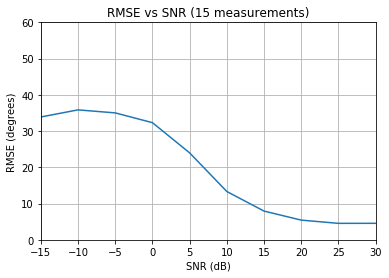

In [44]:
### Test the NN Model ###

for SNR_i in SNR:
    print("\n{} dB SNR --".format(SNR_i))
    test_pred_angles = model.predict(test_data_dict_r[SNR_i])
    print(test_pred_angles.shape)

    test_loss, test_mae, test_mse = model.evaluate(test_data_dict_r[SNR_i],  test_labels_dict_r[SNR_i], verbose=2)
    print('\tTest MSE:', test_mse)
    
    ## Compute the RMSE of the angles
    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(test_angles_dict_r[SNR_i], test_pred_angles)
    rmse_keras = m.result().numpy()
    print('\tKeras RMSE: ', rmse_keras)
    
    RMSE_reg[SNR_i] = rmse_keras

    # Compute the predicted labels and the confusion matrix
#     test_pred_labels = np.argmax(test_predictions, 1)
#     test_confusion = tf.math.confusion_matrix(test_labels_dict[SNR_i],
#                                               test_pred_labels)
#     print(test_confusion)
#     class_confusionMat[SNR_i] = test_confusion

    ## Plot the confusion matrix (see which beams get associated with each other)
#     fig, ax = plt.subplots()
#     ax.matshow(test_confusion)
#     for (i, j), z in np.ndenumerate(test_confusion):
#         ax.text(j, i, '{:d}'.format(z), ha='center', va='center')

#     ax.set_xticklabels(CLASSES)
#     ax.set_yticklabels(CLASSES)
#     ax.xaxis.set_label_position("top")
#     fig.set_size_inches(12, 12)
#     plt.title("Beamtraining Confusion Matrix ({} SNR)".format(SNR_i))
#     plt.xlabel("Predicted angles (degrees)")
#     plt.ylabel("True angles (degrees)")
#     plt.xticks(np.arange(NUM_CLASSES))
#     plt.yticks(np.arange(NUM_CLASSES))
#     plt.savefig('../figures/confusionMatrix_reg_{}meas_{}SNR.png'.format(NUM_MEAS, SNR_i))
#     plt.show()

print("Number of results: {}".format(len(RMSE_reg)))

# Store the results
#all_test_acc[NUM_MEAS] = class_test_acc
all_RMSE_reg[NUM_MEAS] = RMSE_reg

# Plot of accuracy vs. SNR
# plt.figure()
# plt.plot(SNR, list(class_test_acc.values()))
# plt.title("Test Accuracy vs SNR ({} measurements)".format(NUM_MEAS))
# plt.xlabel("SNR (dB)")
# plt.ylabel("Test Accuracy")
# plt.grid(True)
# plt.ylim(0, 1)
# plt.xlim(-15,30)

# Plot of RMSE vs. SNR
plt.figure()
plt.plot(SNR, list(RMSE_reg.values()))
plt.title("RMSE vs SNR ({} measurements)".format(NUM_MEAS))
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)

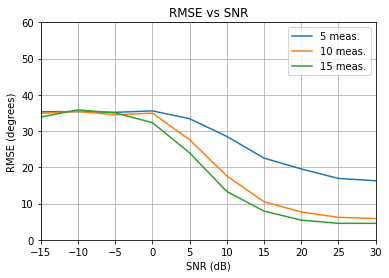

In [45]:
### Plot of the overall metric results for all measurement numbers ###
# Metrics stored in a dictionary of dictionaries
#     Top dictionary (all_*) uses the number of measurements as a key
#     Secondary dictionary (class_*) uses the SNR as a key
# Plots should overlay metric vs. SNR for each number of measurements

meas_plots = list(all_RMSE_reg.keys())
NUM_PLOTS = len(meas_plots)
label_plots = []
for i in np.arange(NUM_PLOTS):
    label_plots.append("{} meas.".format(meas_plots[i]))

# Plot of accuracy vs. SNR
# plt.figure()
# for i in np.arange(NUM_PLOTS):
#     plt.plot(SNR, list(all_test_acc[meas_plots[i]].values()))
# plt.title("Test Accuracy vs SNR")
# plt.xlabel("SNR (dB)")
# plt.ylabel("Test Accuracy")
# plt.grid(True)
# plt.ylim(0, 1)
# plt.xlim(-15,30)
# plt.legend(label_plots)
# plt.savefig('../figures/nn_accuracy.png')

# Plot of RMSE vs. SNR
plt.figure()
for i in np.arange(NUM_PLOTS):
    plt.plot(SNR, list(all_RMSE_reg[meas_plots[i]].values()))
plt.title("RMSE vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("RMSE (degrees)")
plt.grid(True)
plt.ylim(0, 60)
plt.xlim(-15,30)
plt.legend(label_plots)
plt.savefig('../figures/nn_reg_rmse.png')


In [46]:
### Save the results to a CSV for later/combined plotting ###
all_test_res = pd.DataFrame(index=SNR.astype(int))
print(all_test_res.shape)
print(SNR)
for i in np.arange(NUM_PLOTS):
#     all_test_acc_np = np.array(list(all_test_acc[meas_plots[i]].values()))
#     all_test_res.insert(loc=int(i), 
#                         column="Accuracy_{}".format(label_plots[i]),
#                         value=all_test_acc_np)
    all_rmse_reg_np = np.array(list(all_RMSE_reg[meas_plots[i]].values()))
    all_test_res.insert(loc=int(i), 
                        column="RMSE_{}".format(label_plots[i]),
                        value=all_rmse_reg_np)

print(all_test_res)
all_test_res.to_csv("../data/regression_NN_results.csv", index=True)

(10, 0)
[-15 -10  -5   0   5  10  15  20  25  30]
     RMSE_5 meas.  RMSE_10 meas.  RMSE_15 meas.
-15     35.328289      34.888290      33.889206
-10     35.379852      35.416080      35.851391
-5      35.181820      34.488541      35.018875
 0      35.573147      34.953278      32.322292
 5      33.409790      27.597979      23.989941
 10     28.529898      17.621866      13.325187
 15     22.547327      10.511057       7.925580
 20     19.561069       7.668045       5.431944
 25     16.929165       6.201704       4.540309
 30     16.294001       5.887393       4.549653
